# Normal modes frequency and Jij

In [29]:
# from qutip import *
from scipy.optimize import fsolve, leastsq,root,brentq,newton,curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero

import os
# import TimeTagger
import matplotlib
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

The goal is to calculate the equilibrium positions, axial normal modes(and maybe CZ gate validity?) following the James1998 article, we'll also add the calculation of the radial mode and from there we can start the Qsim error analysis. 

Potential energy of the ion chain:

$V=\sum_{m=1}^{N} \frac{1}{2} M \omega^{2} x_{m}(t)^{2}+\sum_{n, m=1 \atop m \neq n}^{N} \frac{Z^{2} e^{2}}{8 \pi \epsilon_{0}} \frac{1}{\left|x_{n}(t)-x_{m}(t)\right|}$

Then equilibrium position is determined by:

$\left[\frac{\partial V}{\partial x_{m}}\right]_{x_{m}=x_{m}^{(0)}}=0$

Rewrite this in the length unit $l=(\frac{ e^{2}}{4 \pi \epsilon_{0} M \omega_z^{2}})^{1/3}$, we have: 

$u_{m}-\sum_{n=1}^{m-1} \frac{1}{\left(u_{m}-u_{n}\right)^{2}}+\sum_{n=m+1}^{N} \frac{1}{\left(u_{m}-u_{n}\right)^{2}}=0 \quad(m=1,2, \dots N)$


In [30]:
def Eqposition(N):
    p=np.empty(shape=(N))
    def func(u): # the equations
        for m in range(N):
            sum1=0
            sum2=0
            for n in range(m):
                sum1+=1/(u[m]-u[n])**2
            # sum1 = np.sum(1/(u[m]-u[:m])**2)
            for n in range(m+1,N):
                sum2+=1/(u[m]-u[n])**2
            p[m]=u[m]-sum1+sum2
        return p
    guess=np.empty(shape=(N))
    for i in range(N):
        guess[i]=3.94*(N**0.387)*np.sin(1/3*np.arcsin(1.75*N**(-0.982)*((i+1)-(N+1)/2))) # initial guess function
    x0=fsolve(func,guess,factor=0.01,xtol=1e-6, maxfev=100000)
    return(np.round(x0,5))
    print(func(x0))

Tried using symmetry of the solutions for optimazation but that didn't work. 

In [31]:
def Eqposition2(N):
    t0 = time()
    def func(u): #the equations
        p=np.empty(shape=(N))
        for m in range(N):
            sum1=0
            sum2=0
            for n in range(m):
                sum1+=1/(u[m]-u[n])**2
            for n in range(m+1,N):
                sum2+=1/(u[m]-u[n])**2
            p[m]=u[m]-sum1+sum2
        return p
    def dfunc(u): # first order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            sum1=0
            sum2=0
            for n in range(m):
                sum1+=1/(u[m]-u[n])**3
            for n in range(m+1,N):
                sum2+=1/(u[m]-u[n])**3
            p[m]=1+2*sum1-2*sum2
        return p
    def ddfunc(u): # second order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            sum1=0
            sum2=0
            for n in range(m):
                sum1+=1/(u[m]-u[n])**4
            for n in range(m+1,N):
                sum2+=1/(u[m]-u[n])**4
            p[m]=sum1-sum2
        return p
    guess=np.empty(shape=(N))
    for i in range(N):
        guess[i]=3.94*(N**0.387)*np.sin(1/3*np.arcsin(1.75*N**(-0.982)*((i+1)-(N+1)/2))) # initial guess function
    x0=newton(func,guess,fprime=dfunc,fprime2=ddfunc,maxiter=1000000) # newton method
    return(np.round(x0,5))
    print(time()-t0)
    print(func(x0))

In [32]:
def Eqposition3(N):
    t0 = time()
    
    def func(u): #the equations
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=u[m]-np.sum(1/(u[m]-u[:m])**2)+np.sum(1/(u[m]-u[m+1:])**2)
        return p
    
    def dfunc(u): # first order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=1+2*np.sum(1/(u[m]-u[:m])**3)-2*np.sum(1/(u[m]-u[m+1:])**3)
        return p
    
    def ddfunc(u): # second order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=np.sum(1/(u[m]-u[:m])**4) - np.sum(1/(u[m]-u[m+1:])**4)
        return p
    
    ni = np.arange(0,N)
    guess = 3.94*(N**0.387)*np.sin(1/3*np.arcsin(1.75*N**(-0.982)*((ni+1)-(N+1)/2)))
    
    x0=newton(func,guess,fprime=dfunc,maxiter=100000) # newton method
    
    return(np.round(x0,5))
    print('Time: ',time()-t0)
    print(func(x0))

In [33]:
def quarticEqposition(N,k,l):
    t0 = time()
    
    def func(u): #the equations
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=k*u[m]+l*(u[m]**3)-np.sum(1/(u[m]-u[:m])**2)+np.sum(1/(u[m]-u[m+1:])**2)
        return p
    
    def dfunc(u): # first order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=k+l*3*(u[m]**2)+2*np.sum(1/(u[m]-u[:m])**3)-2*np.sum(1/(u[m]-u[m+1:])**3)
        return p
    
    def ddfunc(u): # second order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=l*6*u[m]+np.sum(1/(u[m]-u[:m])**4) - np.sum(1/(u[m]-u[m+1:])**4)
        return p
    
    ni = np.arange(0,N)
    guess = 3.94*(N**0.387)*np.sin(1/3*np.arcsin(1.75*N**(-0.982)*((ni+1)-(N+1)/2)))
    
    x0=newton(func,guess,fprime=dfunc,fprime2=ddfunc,maxiter=100000) # newton method
    
    return(np.round(x0,5))
    print('Time: ',time()-t0)
    print(func(x0))

First of all, let's analysis the trap frequency in our case

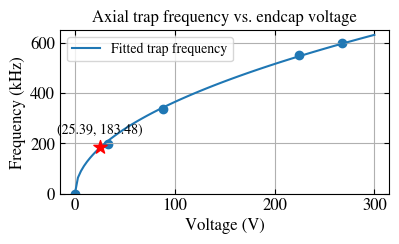

The frequency for a voltage of 25.39 V is approximately 183.48 kHz.


In [34]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the data
freq = np.array([0, 197.235, 338, 549, 598])
voltage = np.array([0, 32.8, 88., 224.15, 267.45])

# Non-linear model fit
def model(v, C):
    return C * np.sqrt(v)

# Fit the model to the data
popt, pcov = curve_fit(model, voltage, freq)

# Create the plot
# Re-plotting the binned data with the corrected windows
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.rc('font', family='STIXGeneral')

# Scatter plot of the data
plt.scatter(voltage, freq, color='C0')

# Plot the fitted model
voltage_line = np.linspace(0, 300, 100)
plt.plot(voltage_line, model(voltage_line, *popt), color='C0', label='Fitted trap frequency')

# Setting plot title and labels
plt.title('Axial trap frequency vs. endcap voltage', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel('Voltage (V)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Frequency (kHz)', fontdict={'family': 'STIXGeneral', 'size': 12})

# Set plot limits and tick properties
plt.ylim(0, 650)
plt.xticks(fontproperties='STIXGeneral', size=12)
plt.yticks(fontproperties='STIXGeneral', size=12)

# Grid and additional matplotlib parameters
plt.grid(True)
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# Input new voltage value
# new_voltage = float(input("Enter new voltage value: "))
# new_voltage = 24.235
new_voltage = (29.82 + 20.96) / 2
new_freq = model(new_voltage, *popt)

# Highlight the new point on the plot with a star marker
plt.scatter([new_voltage], [new_freq], color='red', s=100, zorder=5, marker='*')
plt.annotate(f'({new_voltage}, {new_freq:.2f})', (new_voltage, new_freq), textcoords="offset points", xytext=(0,10), ha='center')
plt.legend()

# Save and show the plot
# plt.savefig('./frequency_vs_voltage_data.jpg')

pdf_filename = 'Trap_frequency.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

# Print the calculated frequency
print(f"The frequency for a voltage of {new_voltage} V is approximately {new_freq:.2f} kHz.")


Secondly, we can calculate ions' distance

In [35]:
N = 9   # Number of ions
wz = 0.17926e6    # Axial trap freq

l = ((1.6e-19)**2*9e9/(40*1.66e-27*(2*np.pi*wz)**2))**(1/3)*1e6
ion_position = Eqposition3(N) * l

'''
# The original code
l=((1.6e-19)**2*9e9/(40*1.66e-27*(2*np.pi*0.246e6)**2))**(1/3)*1e6 #wz = 0.246e6, axial freq 
ion_position =Eqposition3(10)*l
'''

print(ion_position)

[-37.4834494  -26.42746388 -17.054294    -8.38512928  -0.
   8.38512928  17.054294    26.42746388  37.4834494 ]


And then we can generate plots and calculate cumulative distances for updating the AWG's control function

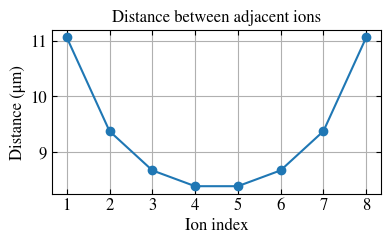

Cumulative distances:  [-37.483 -26.427 -17.054  -8.385   0.      8.386  17.055  26.428  37.484]
Ion positions:  [11.05598552  9.37316988  8.66916473  8.38512928  8.38512928  8.66916473
  9.37316988 11.05598552]


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Update matplotlib parameters
matplotlib.rcParams.update({
    "font.family": "STIXGeneral",
    "xtick.labelsize": 12,
    "xtick.direction": "in",
    "xtick.major.pad": 3,
    "xtick.top": True,
    "ytick.labelsize": 12,
    "ytick.direction": "in",
    "ytick.right": True,
    "axes.labelsize": 12,
    "axes.labelpad": 3,
    "axes.grid": True
})

# Example ion_position array, replace this with your actual array
# ion_position = np.array([-33.33947806, -23.50578365, -15.16886172, -7.45811386, 0., 7.45811386, 15.16886172, 23.50578365, 33.33947806])

# Calculating distances between ions
distances = np.diff(ion_position)

# Define the x-coordinates for the plot
x_coords = np.arange(1, len(ion_position))  # Indices from 1 to len(ion_position) - 1

# Plotting
half_column_width_inches = 4.25
aspect_ratio = 2
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.plot(x_coords, distances, 'o-', label='Distances between ions')
plt.xlabel('Ion index', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Distance (μm)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.title('Distance between adjacent ions', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xticks(np.arange(1, len(ion_position)))  # Set x-axis ticks
plt.grid(True)

# Save the plot
pdf_filename = 'Ion_distance.pdf'  # Specify the path and filename
plt.savefig(pdf_filename, format='pdf')
plt.show()

# Print cumulative distances
cumulative_distances = np.cumsum(distances)
cumulative_distances_str = " , ".join([f"{dist:.3f}" for dist in cumulative_distances])
cumulative_distances = np.array([0, 11.056 , 20.429 , 29.098 , 37.483 , 45.869 , 54.538 , 63.911 , 74.967])
print("Cumulative distances: ", cumulative_distances)
print("Ion positions: ", distances)

Finally, since it is really pain in the ass to update AWG shuttling function everytime, we can write a script to help us generate that everytime we have a new ions' distance data

In [37]:
import numpy as np

def generate_code_file(distances):
    if len(distances) != 8:
        raise ValueError("The distance array must contain exactly 8 elements for 9 ions.")

    cumulative_distances = [0] + list(np.cumsum(distances))

    k1, k2, k3 = 1.0, -1.5e5, 6.0e9
    base_time = 5  # Starting time in microseconds

    with open('equation_editor_code.txt', 'w') as file:
        file.write("range(0us, 5us)\n\n0\n\n")

        for i, (distance, cum_distance) in enumerate(zip(distances, cumulative_distances)):
            start_time = base_time + 20 * i
            end_time = start_time + 10

            # For each distance
            range_code = f"range({start_time}us, {end_time}us)\n\n"
            function_code = f"k1 = 1.0\nk2 = -1.5e5\nk3 = 6.0e9\n\n"
            function_code += f"-{distance:.3f}e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -({cum_distance:.3f}e-6)\n\n"
            file.write(range_code)
            file.write(function_code)

            start_time += 10
            end_time = start_time + 10

            # For each distance
            range_code = f"range({start_time}us, {end_time}us)\n\n"
            function_code = f"-({cum_distance+distance:.3f}e-6)\n\n"
            file.write(range_code)
            file.write(function_code)

        # final_cum_distance = cumulative_distances[-1]
        # final_range_code = f"range({base_time}us, {base_time + 10}us)\n\n-{final_cum_distance:.3f}e-6"
        # file.write(final_range_code)

    print("Code file 'equation_editor_code.txt' generated successfully.")

# Example usage with a given distance array
distances = distances    #np.array([8.953, 7.590, 7.020, 6.790, 6.790, 7.020, 7.590, 8.953])
generate_code_file(distances)

Code file 'equation_editor_code.txt' generated successfully.


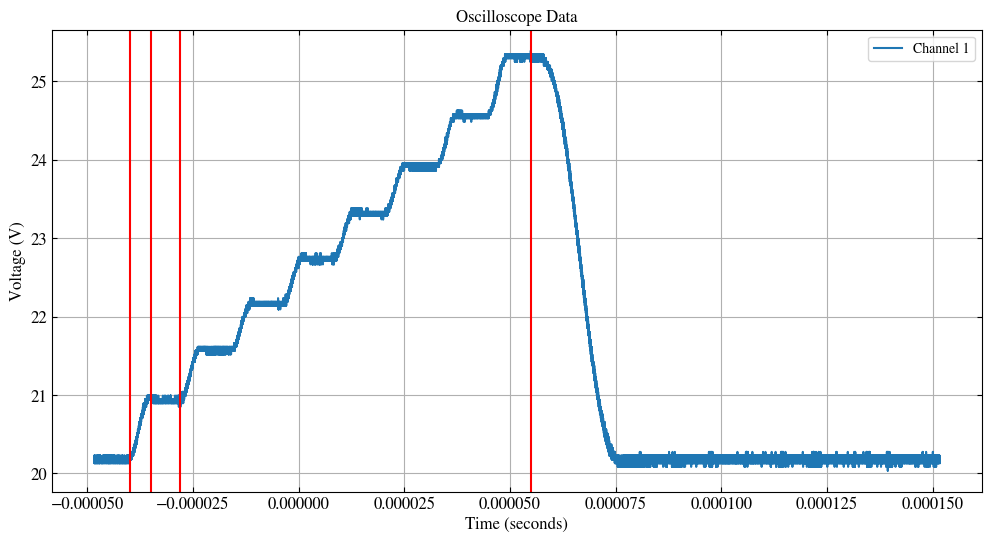

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/Users/bingran.you/SynologyDrive/Multiplexing/#5 Ion Shuttling/Maggie\'s simulation/Ion-Shuttling-Simulation-main/RigolDS0_123.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

plt.figure(figsize=(12, 6))
plt.plot(data['Time(s)'], data['CH2(V)'], label='Channel 1')
plt.axvline(-0.000040, color='r')
plt.axvline(-0.000035, color='r')
plt.axvline(-0.000028, color='r')
plt.axvline(0.000055, color='r')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (V)')
plt.title('Oscilloscope Data')
plt.grid(True)
plt.legend()
plt.show()

    Time(s)     CH2(V)
1 -0.000048  20.177079
2 -0.000048  20.178035
3 -0.000048  20.175644
4 -0.000048  20.172775
5 -0.000048  20.168950


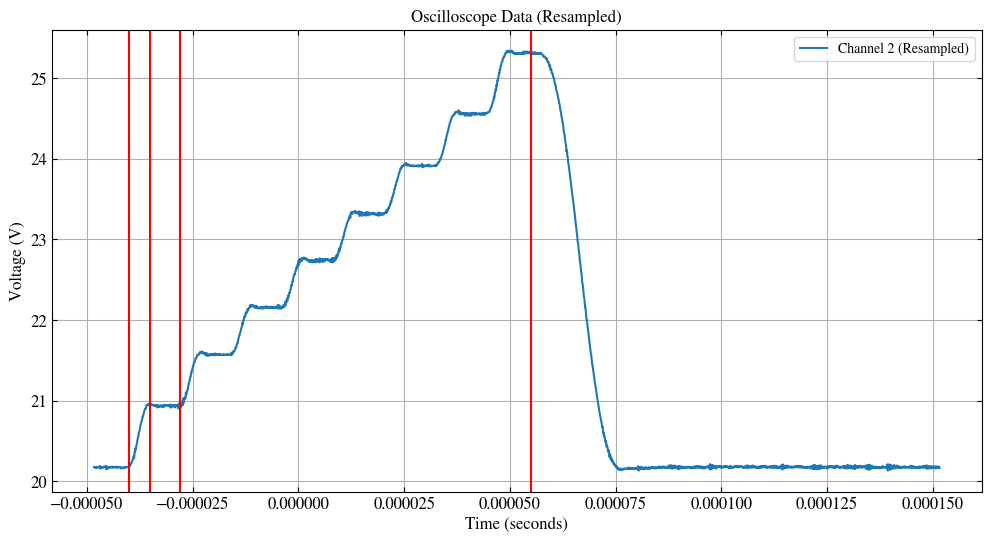

In [39]:
import os
# import TimeTagger
import matplotlib
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

# Load the CSV file
# file_path = 'D:/Google_Drive/Experimental_Data/Multiplexing/Others/RigolDS0_123.csv'
data = pd.read_csv(file_path)

# Resample the data by taking the average of every 1000 points
real_data_resampled = data.groupby(np.arange(len(data)) // 200).mean()

# Remove the first 100 points from the resampled data
real_data_resampled = real_data_resampled.iloc[1:]

# Display the first few rows of the modified resampled dataframe to understand its structure
print(real_data_resampled.head())

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(real_data_resampled['Time(s)'], real_data_resampled['CH2(V)'], label='Channel 2 (Resampled)')
plt.axvline(-0.000040, color='r')
plt.axvline(-0.000035, color='r')
plt.axvline(-0.000028, color='r')
plt.axvline(0.000055, color='r')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (V)')
plt.title('Oscilloscope Data (Resampled)')
plt.grid(True)
plt.legend()
plt.show()

# # Save the modified resampled data to a new CSV file without header
# new_file_path = 'D:/Google_Drive/Experimental_Data/Multiplexing/Others/RigolDS0_123_new_resampled.csv'
# real_data_resampled.to_csv(new_file_path, header=False, index=False)

Another method: coding the shuttling function in a CSV file

   Time (us)         Value
1   0.000001  0.000000e+00
2   0.000002  0.000000e+00
3   0.000003  0.000000e+00
4   0.000004  0.000000e+00
5   0.000005 -2.354911e-08


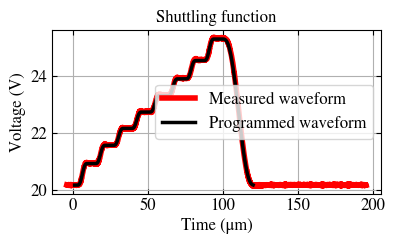

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

def evaluate_shuttling_function(t):
    # Constants
    k1 = 1.0
    k2 = -1.5e5
    k3 = 6.0e9

    # Check the time range and apply the corresponding formula
    if 0 <= t < 5e-6:  # range 0us to 5us
        return 0
    elif 5e-6 <= t < 15e-6:  # range 5us to 15us
        t0 = 5e-6
        t_adjusted = t - t0
        # -11.056e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(0.000e-6)
        return -11.056e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 0.000e-6
    elif 15e-6 <= t < 25e-6:  # range 15us to 25us
        t0 = 15e-6
        return -11.056e-6
    elif 25e-6 <= t < 35e-6:  # range 25us to 35us
        t0 = 25e-6
        t_adjusted = t - t0
        # -9.373e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(11.056e-6)
        return -9.373e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 11.056e-6
    elif 35e-6 <= t < 45e-6:  # range 35us to 45us
        t0 = 35e-6
        return -20.429e-6
    elif 45e-6 <= t < 55e-6:  # range 45us to 55us
        t0 = 45e-6
        t_adjusted = t - t0
        # -8.669e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(20.429e-6)
        return -8.669e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 20.429e-6
    elif 55e-6 <= t < 65e-6:  # range 55us to 65us
        t0 = 55e-6
        return -29.098e-6
    elif 65e-6 <= t < 75e-6:  # range 65us to 75us
        t0 = 65e-6
        t_adjusted = t - t0
        # -8.385e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(29.098e-6)
        return -8.385e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 29.098e-6
    elif 75e-6 <= t < 85e-6:  # range 75us to 85us
        t0 = 75e-6
        return -37.483e-6
    elif 85e-6 <= t < 95e-6:  # range 85us to 95us
        t0 = 85e-6
        t_adjusted = t - t0
        # -8.385e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(37.483e-6)
        return -8.385e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 37.483e-6
    elif 95e-6 <= t < 105e-6:  # range 95us to 105us
        t0 = 95e-6
        return -45.869e-6
    elif 105e-6 <= t < 115e-6:  # range 105us to 115us
        t0 = 105e-6
        t_adjusted = t - t0
        # -8.669e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(45.869e-6)
        return -8.669e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 45.869e-6
    elif 115e-6 <= t < 125e-6:  # range 115us to 125us
        t0 = 115e-6
        return -54.538e-6
    elif 125e-6 <= t < 135e-6:  # range 125us to 135us
        t0 = 125e-6
        t_adjusted = t - t0
        # -9.373e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(54.538e-6)
        return -9.373e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 54.538e-6
    elif 135e-6 <= t < 145e-6:  # range 135us to 145us
        t0 = 135e-6
        return -63.911e-6
    elif 145e-6 <= t < 155e-6:  # range 145us to 155us
        t0 = 145e-6
        t_adjusted = t - t0
        # -11.056e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(63.911e-6)
        return -11.056e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 63.911e-6
    elif 155e-6 <= t < 165e-6:  # range 155us to 165us
        t0 = 155e-6
        return -74.967e-6
    elif 165e-6 <= t < 200e-6:
        t_adjusted = t - 165e-6
        return 1.7485e10 * (t_adjusted**3) - 7.49358e14 * (t_adjusted**4) + 8.56409e18 * (t_adjusted**5) -74.967e-6
    else:
        return 0

# Total number of points and samples per second
num_points = 1e4
samples_per_second = 5e7  # 50,000,000 samples per second

# Total time range in microseconds
total_time_us = 200 * 1e-6

# Generate time points
time_points = np.linspace(0, total_time_us, int(num_points))

# Calculate values for each time point using evaluate_shuttling_function
calculated_values = [evaluate_shuttling_function(t) for t in time_points]

# Create DataFrame
df = pd.DataFrame({
    'Time (us)': time_points,
    'Value': calculated_values
})

# Save to CSV
csv_filename = 'shuttling_function.csv'
df.to_csv(csv_filename, index=False)

# Load the CSV file
file_path = csv_filename
data = pd.read_csv(file_path)

# Resample the data if necessary
data_resampled = data.groupby(np.arange(len(data)) // 50).mean()

data_resampled = data_resampled.iloc[1:]

# real_data_resampled = real_data_resampled.iloc[100:]

data_resampled = data_resampled.iloc[:-1]

# real_data_resampled = real_data_resampled.iloc[:-1350]

# Display the first few rows of the modified resampled dataframe to understand its structure
print(data_resampled.head())

# Plotting
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.title('Shuttling function', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.plot((real_data_resampled['Time(s)'] + 0.000044) * 1e6, real_data_resampled['CH2(V)'], 'r', linewidth=4, label='Measured waveform')
plt.plot(data_resampled[r'Time (us)'] * (0.605) * 1e6, data_resampled['Value'] * (-0.0682*1e6) + 20.17, 'black', linewidth=2.5, label='Programmed waveform')

plt.xlabel(r'Time (μm)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Voltage (V)', fontdict={'family': 'STIXGeneral', 'size': 12})
# plt.xlim(0, 105)
# plt.title('Endcap voltage ramping function', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.grid(True)
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
pdf_filename = 'Shuttling_function.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

      Time (us)         Value
1  9.983998e-07  0.000000e+00
2  1.668467e-06  0.000000e+00
3  2.338534e-06 -7.818368e-09
4  3.008601e-06 -1.059150e-07
5  3.678668e-06 -4.116255e-07


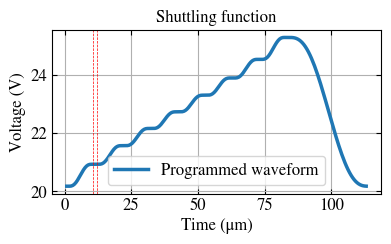

In [41]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

def evaluate_shuttling_function(t):
    # Constants
    k1 = 1.0
    k2 = -1.5e5
    k3 = 6.0e9

    # Check the time range and apply the corresponding formula
    if 0 <= t < 2e-6:  # range 0us to 5us
        return 0
    elif 2e-6 <= t < 13e-6:  # range 5us to 15us
        t0 = 2e-6
        t_adjusted = t - t0
        # -11.056e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(0.000e-6)
        return -11.056e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 0.000e-6
    elif 13e-6 <= t < 15e-6:  # range 15us to 25us
        t0 = 13e-6
        return -11.056e-6
    elif 15e-6 <= t < 25e-6:  # range 25us to 35us
        t0 = 15e-6
        t_adjusted = t - t0
        # -9.373e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(11.056e-6)
        return -9.373e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 11.056e-6
    elif 25e-6 <= t < 27e-6:  # range 35us to 45us
        t0 = 25e-6
        return -20.429e-6
    elif 27e-6 <= t < 37e-6:  # range 45us to 55us
        t0 = 27e-6
        t_adjusted = t - t0
        # -8.669e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(20.429e-6)
        return -8.669e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 20.429e-6
    elif 37e-6 <= t < 39e-6:  # range 55us to 65us
        t0 = 37e-6
        return -29.098e-6
    elif 39e-6 <= t < 49e-6:  # range 65us to 75us
        t0 = 39e-6
        t_adjusted = t - t0
        # -8.385e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(29.098e-6)
        return -8.385e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 29.098e-6
    elif 49e-6 <= t < 51e-6:  # range 75us to 85us
        t0 = 49e-6
        return -37.483e-6
    elif 51e-6 <= t < 61e-6:  # range 85us to 95us
        t0 = 51e-6
        t_adjusted = t - t0
        # -8.385e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(37.483e-6)
        return -8.385e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 37.483e-6
    elif 61e-6 <= t < 63e-6:  # range 95us to 105us
        t0 = 61e-6
        return -45.869e-6
    elif 63e-6 <= t < 73e-6:  # range 105us to 115us
        t0 = 63e-6
        t_adjusted = t - t0
        # -8.669e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(45.869e-6)
        return -8.669e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 45.869e-6
    elif 73e-6 <= t < 75e-6:  # range 115us to 125us
        t0 = 73e-6
        return -54.538e-6
    elif 75e-6 <= t < 85e-6:  # range 125us to 135us
        t0 = 75e-6
        t_adjusted = t - t0
        # -9.373e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(54.538e-6)
        return -9.373e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 54.538e-6
    elif 85e-6 <= t < 87e-6:  # range 135us to 145us
        t0 = 85e-6
        return -63.911e-6
    elif 87e-6 <= t < 97e-6:  # range 145us to 155us
        t0 = 87e-6
        t_adjusted = t - t0
        # -11.056e-6 * 1.0e16*(k1*(t^3)+k2*(t^4)+k3*(t^5)) -(63.911e-6)
        return -11.056e-6 * 1.0e16 * (k1 * (t_adjusted**3) + k2 * (t_adjusted**4) + k3 * (t_adjusted**5)) - 63.911e-6
    elif 97e-6 <= t < 99e-6:  # range 155us to 165us
        t0 = 97e-6
        return -74.967e-6
    elif 99e-6 <= t < 134e-6:
        t_adjusted = t - 99e-6
        return 1.7485e10 * (t_adjusted**3) - 7.49358e14 * (t_adjusted**4) + 8.56409e18 * (t_adjusted**5) -74.967e-6
    else:
        return 0

# Total number of points and samples per second
num_points = 1e4
samples_per_second = 5e7  # 50,000,000 samples per second

# Total time range in microseconds
total_time_us = 134 * 1e-6

# Generate time points
time_points = np.linspace(0, total_time_us, int(num_points))

# Calculate values for each time point using evaluate_shuttling_function
calculated_values = [evaluate_shuttling_function(t) for t in time_points]

# Create DataFrame
df = pd.DataFrame({
    'Time (us)': time_points,
    'Value': calculated_values
})

# Save to CSV
csv_filename = 'shuttling_function.csv'
df.to_csv(csv_filename, index=False)

# Load the CSV file
file_path = csv_filename
data = pd.read_csv(file_path)

# Resample the data if necessary
data_resampled = data.groupby(np.arange(len(data)) // 50).mean()

data_resampled = data_resampled.iloc[1:]

# real_data_resampled = real_data_resampled.iloc[100:]

data_resampled = data_resampled.iloc[:-1]

# real_data_resampled = real_data_resampled.iloc[:-1350]

# Display the first few rows of the modified resampled dataframe to understand its structure
print(data_resampled.head())

# Plotting
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.title('Shuttling function', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.plot(data_resampled[r'Time (us)'] * (0.85) * 1e6, data_resampled['Value'] * (-0.0682*1e6) + 20.17, 'C0', linewidth=2.5, label='Programmed waveform')
plt.axvline(10.5, color='r', linewidth=0.5, linestyle='--')
plt.axvline(10.5 + 1.7, color='r', linewidth=0.5, linestyle='--')

# plt.plot((real_data_resampled['Time(s)'] + 0.000044) * 1e6, real_data_resampled['CH2(V)'], 'r', linewidth=4, label='Measured waveform')
# plt.plot(data_resampled[r'Time (us)'] * (0.605) * 1e6, data_resampled['Value'] * (-0.0682*1e6) + 20.17, 'black', linewidth=2.5, label='Programmed waveform')

plt.xlabel(r'Time (μm)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Voltage (V)', fontdict={'family': 'STIXGeneral', 'size': 12})
# plt.xlim(0, 105)
# plt.title('Endcap voltage ramping function', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.grid(True)
legend_fontsize = 12
plt.legend(fontsize=legend_fontsize)
pdf_filename = 'Shuttling_function_new.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

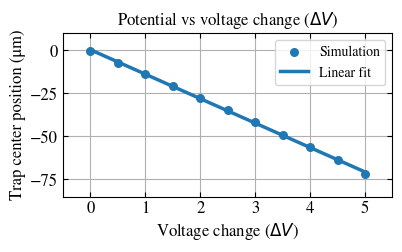

In [42]:
# delta=[i for i in range(20)]
# delta=np.array(delta)
# y = 10**6*np.array(pos)
# np.save("delta.npy", delta)
# np.save("y.npy", y)
# plt.plot(delta, y)
# plt.xlabel('delta')
# plt.ylabel('minimum point of the potential/µm')
# plt.show()

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import linregress

matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

delta = np.load("delta.npy")[:11]
y = np.load("y.npy")[:11]

# Perform a linear regression
slope, intercept, r_value, p_value, std_err = linregress(delta, y)

# Define the linear model function
def model(x):
    return slope * x + intercept

# Generate fitted y-values
fitted_y = model(delta)

half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.rc('font',family='STIXGeneral')
# plt.scatter([new_voltage], [new_freq], color='red', s=100, zorder=5, marker='*')
# plt.annotate(f'({new_voltage}, {new_freq:.2f})', (new_voltage, new_freq), textcoords="offset points", xytext=(0,10), ha='center')
# Plot the original data
plt.scatter(delta / 2, y, color='C0', s=30, zorder=5, marker='o', label="Simulation")

# Plot the fitted line
plt.plot(delta / 2, fitted_y, color='C0', linewidth=2.5, label="Linear fit")

# Title and labels
plt.title(r'Potential vs voltage change ($\Delta$$V$)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r"Voltage change ($\Delta V$)", fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Trap center position (μm)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlim(-0.5, 5.5)
plt.ylim(-85, 10)
plt.yticks(fontproperties='STIXGeneral', size=12)
plt.xticks(fontproperties='STIXGeneral', size=12)
plt.grid(True)
plt.legend()
pdf_filename = 'potential_vs_voltage_delta.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

The total counts: 0.0


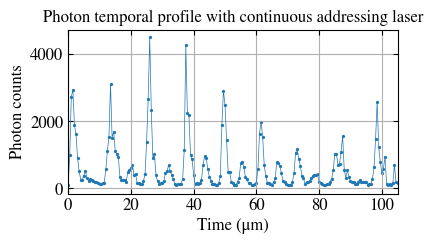

In [43]:
start_point = 9
end_point = 10

path = "/Users/bingran.you/SynologyDrive/Multiplexing/Data Processing/Experimental_Data/Multiplexing/TimeTagger_Data"
# file_name = "/Histogram_2023-12-22_172156.txt"
file_name = "/Histogram_2024-01-14_152137.txt"
raw_data = np.loadtxt(path+file_name, \
                        delimiter='\t', dtype='str')
data = np.array(raw_data[1:]).astype(dtype="f").transpose()

length = len(raw_data)

start_point = 290 #first five points are not good
end_point = start_point + 20

time_bins = data[0, :] / 1e6
counts = data[1, :]
background_counts = (np.sum(counts[0:start_point])) / start_point
# counts -= background_counts
counts_sum = np.sum(counts[start_point:end_point])
title = "Photon temporal profile with continuous addressing laser"

print('The total counts:', counts_sum)

'''plt.plot'''
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.rc('font',family='STIXGeneral')
plt.plot(time_bins, counts, c='C0', linewidth=0.5)
plt.scatter(time_bins, counts, c='C0', linewidths=0.1, s=5)

# # Defining a function to plot and print each pair of start and end times
# def plot_time_pair(start_time, end_time, i = 1):
#     plt.axvline(start_time, color='r', linewidth=0.5, linestyle='--')
#     print("Start time =", start_time, "us")
#     if(i == 0):
#         plt.axvline(end_time, color='r', linewidth=0.5, linestyle='--', label='300 ns time filtering')
#     else:
#         plt.axvline(end_time, color='r', linewidth=0.5, linestyle='--')
#     print("End time =", end_time, "us")

# # Plotting each pair
# plot_time_pair(Start_time1, End_time1, i = 0)
# plot_time_pair(Start_time2, End_time2)
# plot_time_pair(Start_time3, End_time3)
# plot_time_pair(Start_time4, End_time4)
# plot_time_pair(Start_time5, End_time5)
# plot_time_pair(Start_time6, End_time6)
# plot_time_pair(Start_time7, End_time7)
# plot_time_pair(Start_time8, End_time8)
# plot_time_pair(Start_time9, End_time9)

# plt.axvline(time_bins[start_point], color='r')
# plt.axvline(time_bins[end_point], color='r')
plt.title(title, fontdict={'family' : 'STIXGeneral', 'size':12})
plt.xlabel(r'Time (μm)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Photon counts', fontdict={'family' : 'STIXGeneral', 'size':12})
# plt.ylim(0, np.max(counts) + 2)
plt.xlim(0, 105)
plt.yticks(fontproperties='STIXGeneral', size=12)
plt.xticks(fontproperties='STIXGeneral', size=12)
plt.grid(True)
pdf_filename = 'Single_photon_hist_continuous_addressing.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


7360
7360


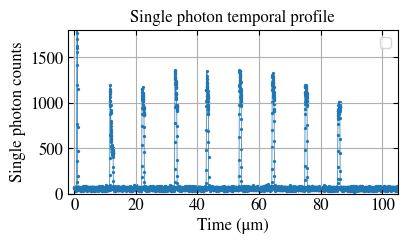

In [44]:
from scipy.signal import find_peaks
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# hist_index = np.load("Single_photon_histogram_index.npy")
# final_hist = np.load("Single_photon_histogram_data.npy")

hist_index = np.load("Single_photon_histogram_index_final.npy")
final_hist = np.load("Single_photon_histogram_data_final.npy")

time_filtering = (0.3) * 1e6

Start_time1 = 1.95
End_time1 = Start_time1 + time_filtering/1e6
Start_time2 = 14.22
End_time2 = Start_time2 + time_filtering/1e6
Start_time3 = 25.7
End_time3 = Start_time3 + time_filtering/1e6
Start_time4 = 38.2
End_time4 = Start_time4 + time_filtering/1e6
Start_time5 = 49.95
End_time5 = Start_time5 + time_filtering/1e6
Start_time6 = 61.7
End_time6 = Start_time6 + time_filtering/1e6
Start_time7 = 73.2
End_time7 = Start_time7 + time_filtering/1e6
Start_time8 = 85.45
End_time8 = Start_time8 + time_filtering/1e6
Start_time9 = 98.7
End_time9 = Start_time9 + time_filtering/1e6

title = "Histogram with 9 ions and addressing laser"
'''plt.plot'''
# Plotting
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.rc('font',family='STIXGeneral')
# plt.bar(hist_index, final_hist, color='C0') #, width=0.1

m = 2  # Number of elements in each bin
# Bin the data
n = len(final_hist)
num_bins = n // m
# binned_data = np.array([final_hist[i*m:(i+1)*m].sum() for i in range(num_bins)])
binned_data = final_hist
# Create a new histogram index for the binned data
binned_hist_index = np.array([hist_index[i*m:(i+1)*m].sum() for i in range(num_bins)])
binned_hist_index = hist_index
plt.scatter(hist_index, final_hist, c='C0', linewidths=0.1, s=5)
plt.plot(hist_index, final_hist, c='C0', linewidth=0.5)

# Defining a function to plot and print each pair of start and end times
def plot_time_pair(start_time, end_time, i = 1):
    plt.axvline(start_time, color='r', linewidth=0.5, linestyle='--')
    print("Start time =", start_time, "us")
    if(i == 0):
        plt.axvline(end_time, color='r', linewidth=0.5, linestyle='--', label='300 ns time filtering')
    else:
        plt.axvline(end_time, color='r', linewidth=0.5, linestyle='--')
    print("End time =", end_time, "us")

# # Plotting each pair
# plot_time_pair(Start_time1, End_time1, i = 0)
# plot_time_pair(Start_time2, End_time2)
# plot_time_pair(Start_time3, End_time3)
# plot_time_pair(Start_time4, End_time4)
# plot_time_pair(Start_time5, End_time5)
# plot_time_pair(Start_time6, End_time6)
# plot_time_pair(Start_time7, End_time7)
# plot_time_pair(Start_time8, End_time8)
# plot_time_pair(Start_time9, End_time9)

# Find peaks with adjusted parameters for better sensitivity
peaks, properties = find_peaks(binned_data, prominence=1)  # Adjust prominence as needed
top_peaks = peaks[np.argsort(properties['prominences'])][-9:]  # Get the highest 9 peaks

print(len(binned_hist_index))
print(len(binned_data))

# plt.title(title, fontdict={'family' : 'STIXGeneral', 'size':12})
# plt.title("Temporal profile of single photon generation", fontdict={'family' : 'STIXGeneral', 'size':12})
plt.title('Single photon temporal profile', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (μm)', fontdict={'family' : 'STIXGeneral', 'size':12})
plt.ylabel('Single photon counts', fontdict={'family' : 'STIXGeneral', 'size':12})
plt.xlim(-2, 105)
# plt.xlim(Start_time1 - 10, End_time1 + 10)
plt.ylim(0, 1800)
plt.yticks(fontproperties='STIXGeneral', size=12)
plt.xticks(fontproperties='STIXGeneral', size=12)
plt.grid(True)
plt.legend()
# plt.savefig('./'+file_name_PMT+' _data.jpg')
# Save the figure with tight bounding box
pdf_filename = 'Single_photon_hist.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

0
1
2
3
4
5
6
7
8
9


KeyboardInterrupt: 

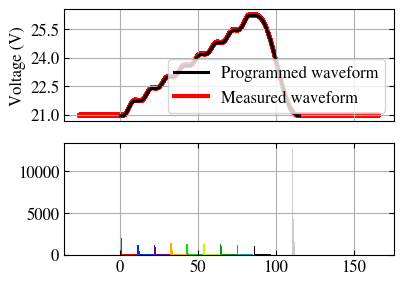

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from matplotlib.ticker import MaxNLocator

# Load the CSV file
file_path = 'RigolDS4.csv'
data = pd.read_csv(file_path)

# Applying a rolling average for smoothing
# Choose a window size; larger values result in smoother data
window_size = 10
smoothed_data = data.rolling(window=window_size).mean()

half_column_width_inches = 4.25
aspect_ratio = 2

# Create subplots with shared x-axis, slightly increased height for clarity
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(half_column_width_inches, 1.5 * (half_column_width_inches / aspect_ratio)))

axs[0].plot(data_resampled['Time (us)'] *0.87* 1e6 - 0.5, data_resampled['Value'] * (-0.0708 * 1e6) + 20.93, 'black', zorder = 2, linewidth=2.2, label='Programmed waveform')
axs[0].plot(smoothed_data['Time(s)'] * 1e6 * 0.96 + 39.9, smoothed_data['CH1(V)'], 'red', linewidth=3, zorder = 1, label='Measured waveform')
axs[0].set_ylabel('Voltage (V)', fontdict={'family': 'STIXGeneral', 'size': 12})
axs[0].legend(fontsize=legend_fontsize)
# Customize the first subplot's y-axis to have a fixed number of ticks
axs[0].yaxis.set_major_locator(MaxNLocator(5))
# Customize the first subplot's x-axis to hide labels and ticks
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Find peaks
peaks, properties = find_peaks(binned_data, prominence=1)  # Adjust prominence as needed
# Select the top peaks based on their prominences (now assuming you want the top 10 for demonstration)
top_peaks_indices = np.argsort(properties['prominences'])[-10:]  # Adjust number of peaks as needed
top_peaks = peaks[top_peaks_indices]
colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(top_peaks)))
errors = np.sqrt(binned_data)

for i, peak in enumerate(top_peaks):
    # peak_area_indices = np.arange(max(0, peak-2), min(len(binned_data), peak+15))
    peak_area_indices = np.arange(max(0, peak), min(len(binned_data), peak+647))
    print(i)
    axs[1].bar(binned_hist_index[peak_area_indices], binned_data[peak_area_indices], color=colors[i], width=0.75)
    # Calculate slightly altered color for error bars
    original_color = colors[i]  # Get the original color
    # Now identify high count indices within the current peak area for error bars
    indices_with_high_counts_peak_area = (binned_data[peak_area_indices] > 300)
    # Convert peak area indices to global indices within the condition
    global_indices = peak_area_indices[indices_with_high_counts_peak_area]

# axs[1].set_xlabel(r'Time (μm)', fontdict={'family': 'STIXGeneral', 'size': 12})
axs[1].set_xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
axs[1].set_ylabel('Counts', fontdict={'family': 'STIXGeneral', 'size': 12})

# Customize the second subplot's y-axis to have a fixed number of ticks
axs[1].yaxis.set_major_locator(MaxNLocator(5))
axs[1].set_yscale('log')

# Adjust the ylim for the second plot as needed
ylim_min, ylim_max = 70, 2500  # Set your desired limits here
axs[1].set_ylim(ylim_min, ylim_max)

# Find peaks with adjusted parameters for better sensitivity
top_peaks = peaks[np.argsort(properties['prominences'])][-10:]  # Attempt to get the highest 9 peaks

# Add vertical dashed lines at each peak for both subplots
for peak in top_peaks:
    axs[0].axvline(x=binned_hist_index[peak], color='grey', linestyle='--', linewidth=0.5)
    axs[1].axvline(x=binned_hist_index[peak], color='grey', linestyle='--', linewidth=0.5)

plt.xlim(0, 89)
axs[0].grid(False)
axs[1].grid(False)
fig.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, hspace=0.02, wspace=0.2)
plt.savefig('Fig_2.pdf', format='pdf', bbox_inches='tight')
plt.show()
print(top_peaks)
print(binned_hist_index[top_peaks[0]])

0
1
2
3
4
5
6
7
8
9


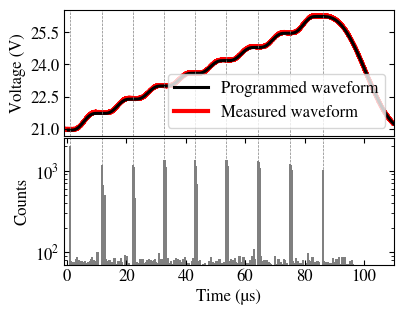

[5514 1419  744 4809 4121 2756 3431 2093   54 7075]
86.15625


In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from matplotlib.ticker import MaxNLocator

# Load the CSV file
file_path = 'RigolDS4.csv'
data = pd.read_csv(file_path)

# Applying a rolling average for smoothing
# Choose a window size; larger values result in smoother data
window_size = 10
smoothed_data = data.rolling(window=window_size).mean()

half_column_width_inches = 4.25
aspect_ratio = 2

# Create subplots with shared x-axis, slightly increased height for clarity
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(half_column_width_inches, 1.5 * (half_column_width_inches / aspect_ratio)))

axs[0].plot(data_resampled['Time (us)'] *0.87* 1e6 - 0.5, data_resampled['Value'] * (-0.0708 * 1e6) + 20.93, 'black', zorder = 2, linewidth=2.2, label='Programmed waveform')
axs[0].plot(smoothed_data['Time(s)'] * 1e6 * 0.96 + 39.9, smoothed_data['CH1(V)'], 'red', linewidth=3, zorder = 1, label='Measured waveform')
axs[0].set_ylabel('Voltage (V)', fontdict={'family': 'STIXGeneral', 'size': 12})
axs[0].legend(fontsize=legend_fontsize)
# Customize the first subplot's y-axis to have a fixed number of ticks
axs[0].yaxis.set_major_locator(MaxNLocator(5))
# Customize the first subplot's x-axis to hide labels and ticks
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Find peaks
peaks, properties = find_peaks(binned_data, prominence=1)  # Adjust prominence as needed
# Select the top peaks based on their prominences (now assuming you want the top 10 for demonstration)
top_peaks_indices = np.argsort(properties['prominences'])[-10:]  # Adjust number of peaks as needed
top_peaks = peaks[top_peaks_indices]
colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(top_peaks)))
errors = np.sqrt(binned_data)

for i, peak in enumerate(top_peaks):
    # peak_area_indices = np.arange(max(0, peak-2), min(len(binned_data), peak+15))
    peak_area_indices = np.arange(max(0, peak), min(len(binned_data), peak+647))
    print(i)
    # axs[1].bar(binned_hist_index[peak_area_indices], binned_data[peak_area_indices], color=colors[i], width=0.75)
    axs[1].bar(binned_hist_index[peak_area_indices], binned_data[peak_area_indices], color='grey', width=0.75)
    # Calculate slightly altered color for error bars
    original_color = colors[i]  # Get the original color
    # Now identify high count indices within the current peak area for error bars
    indices_with_high_counts_peak_area = (binned_data[peak_area_indices] > 300)
    # Convert peak area indices to global indices within the condition
    global_indices = peak_area_indices[indices_with_high_counts_peak_area]

# axs[1].set_xlabel(r'Time (μm)', fontdict={'family': 'STIXGeneral', 'size': 12})
axs[1].set_xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
axs[1].set_ylabel('Counts', fontdict={'family': 'STIXGeneral', 'size': 12})

# Customize the second subplot's y-axis to have a fixed number of ticks
axs[1].yaxis.set_major_locator(MaxNLocator(5))
axs[1].set_yscale('log')

# Adjust the ylim for the second plot as needed
ylim_min, ylim_max = 70, 2500  # Set your desired limits here
axs[1].set_ylim(ylim_min, ylim_max)

# Find peaks with adjusted parameters for better sensitivity
top_peaks = peaks[np.argsort(properties['prominences'])][-10:]  # Attempt to get the highest 9 peaks

# Add vertical dashed lines at each peak for both subplots
for peak in top_peaks:
    axs[0].axvline(x=binned_hist_index[peak], color='grey', linestyle='--', linewidth=0.5)
    axs[1].axvline(x=binned_hist_index[peak], color='grey', linestyle='--', linewidth=0.5)

plt.xlim(-1, 110)
axs[0].grid(False)
axs[1].grid(False)
fig.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, hspace=0.02, wspace=0.2)
plt.savefig('Fig_2.pdf', format='pdf', bbox_inches='tight')
plt.show()
print(top_peaks)
print(binned_hist_index[top_peaks[0]])

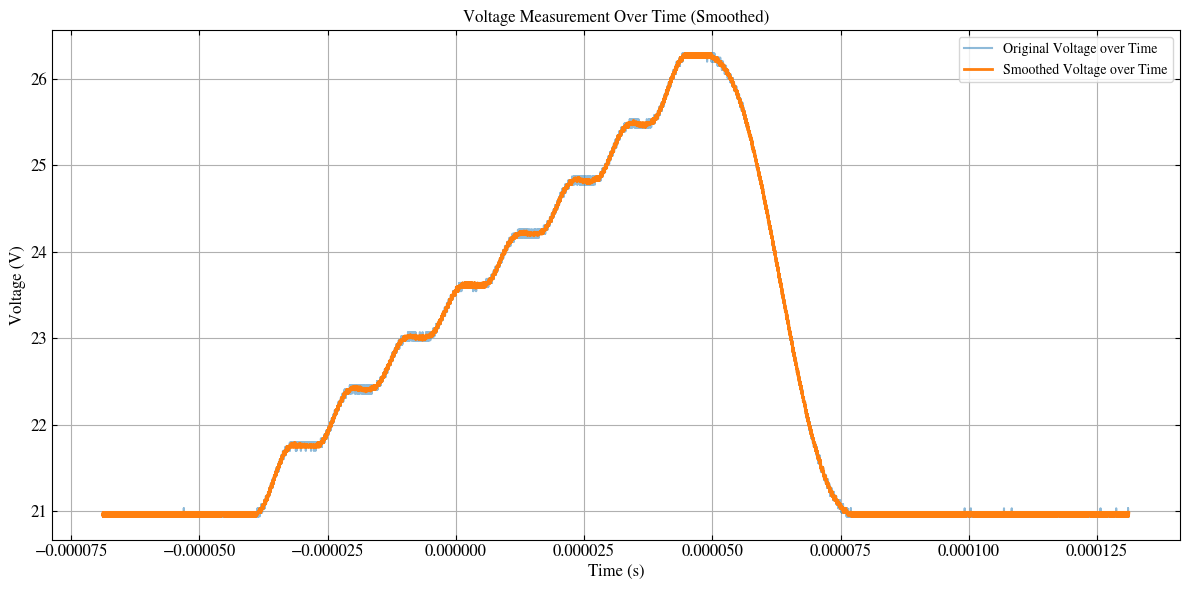

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'RigolDS4.csv'
data = pd.read_csv(file_path)

# Applying a rolling average for smoothing
# Choose a window size; larger values result in smoother data
window_size = 10
smoothed_data = data.rolling(window=window_size).mean()

# Plotting the original data
plt.figure(figsize=(12, 6))
plt.plot(data['Time(s)'], data['CH1(V)'], label='Original Voltage over Time', alpha=0.5)

# Plotting the smoothed data
plt.plot(smoothed_data['Time(s)'], smoothed_data['CH1(V)'], label='Smoothed Voltage over Time', linewidth=2)

plt.title('Voltage Measurement Over Time (Smoothed)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

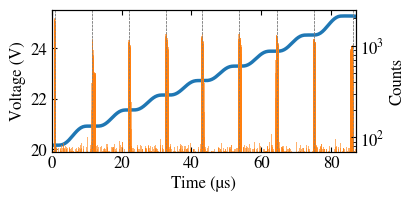

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# Assuming your data is loaded in binned_data, and other settings like half_column_width_inches, aspect_ratio are defined

# Correctly find peaks with prominence information
peaks, properties = find_peaks(binned_data, prominence=0.1, distance=5)

# Select the top peaks based on their prominences (now assuming you want the top 10 for demonstration)
top_peaks_indices = np.argsort(properties['prominences'])[-10:]  # Adjust number of peaks as needed
top_peaks = peaks[top_peaks_indices]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))

# Plotting the waveform
ax1.plot(data_resampled['Time (us)'] * 0.86 * 1e6, data_resampled['Value'] * (-0.0682 * 1e6) + 20.17, 'C0', linewidth=2.5, label='Programmed waveform')
ax1.set_xlabel('Time (µs)', fontsize=12, color='black')  # Set text color to black
ax1.set_ylabel('Voltage (V)', fontsize=12, color='black')  # Set text color to black
ax1.tick_params(axis='y', labelcolor='black')  # Set tick label color to black for y-axis
ax1.tick_params(axis='x', labelcolor='black')  # Set tick label color to black for x-axis
ax1.set_xlim(0, 87)

# Creating a secondary y-axis for counts
ax2 = ax1.twinx()
ax2.bar(binned_hist_index, binned_data, color='C1', width=0.3, alpha=0.6)
ax2.set_ylabel('Counts', fontsize=12, color='black')  # Set text color to black
ax2.tick_params(axis='y', labelcolor='black')  # Set tick label color to black for y-axis
ax2.set_yscale('log')
ax2.set_ylim(70, 2500)

# Drawing vertical dashed lines at each top peak
for peak in top_peaks:
    ax1.axvline(x=binned_hist_index[peak], color='grey', linestyle='--', linewidth=0.5)
    ax2.axvline(x=binned_hist_index[peak], color='grey', linestyle='--', linewidth=0.5)

# Final adjustments
ax1.grid(False)
ax2.grid(False)
fig.tight_layout()

plt.savefig('Fig_combined.pdf', format='pdf', bbox_inches='tight')
plt.show()

KeyboardInterrupt: 

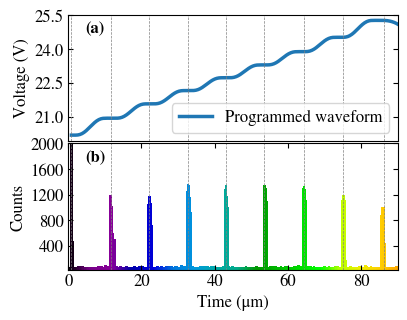

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from matplotlib.ticker import MaxNLocator

hist_index = np.load("Single_photon_histogram_index_new.npy")
final_hist = np.load("Single_photon_histogram_data_new.npy")

# Assuming you have your data loaded in real_data_resampled, data_resampled, binned_hist_index, binned_data
# and your half_column_width_inches, aspect_ratio, legend_fontsize are defined as well
half_column_width_inches = 4.25
aspect_ratio = 2  # You can adjust this for your desired aspect ratio
# Create subplots with shared x-axis, slightly increased height for clarity
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(half_column_width_inches, 1.5 * (half_column_width_inches / aspect_ratio)))

# Plotting the first plot
# axs[0].plot((real_data_resampled['Time(s)'] + 0.000044) * 1e6, real_data_resampled['CH2(V)'], 'r', linewidth=4, label='Measured waveform')
axs[0].plot(data_resampled['Time (us)'] *0.86* 1e6, data_resampled['Value'] * (-0.0682 * 1e6) + 20.17, 'C0', linewidth=2.5, label='Programmed waveform')
axs[0].set_ylabel('Voltage (V)', fontdict={'family': 'STIXGeneral', 'size': 12})
axs[0].legend(fontsize=legend_fontsize)

# Move (a) inside the plot
axs[0].text(0.05, 0.95, '(a)', transform=axs[0].transAxes, size=12, weight='bold', va='top')

# Customize the first subplot's y-axis to have a fixed number of ticks
axs[0].yaxis.set_major_locator(MaxNLocator(5))

# Customize the first subplot's x-axis to hide labels and ticks
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plotting the second plot initially
axs[1].bar(hist_index, final_hist, color='C0', width=0.02)

# Find peaks
peaks, properties = find_peaks(binned_data, prominence=1)  # Adjust prominence as needed
colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(peaks)))

for i, peak in enumerate(peaks):
    peak_area_indices = np.arange(max(0, peak-5), min(len(binned_data), peak+6))
    axs[1].bar(binned_hist_index[peak_area_indices], binned_data[peak_area_indices], color=colors[i], width=0.75)

axs[1].set_xlabel(r'Time (μm)', fontdict={'family': 'STIXGeneral', 'size': 12})
axs[1].set_ylabel('Counts', fontdict={'family': 'STIXGeneral', 'size': 12})

# Move (b) inside the plot
axs[1].text(0.05, 0.95, '(b)', transform=axs[1].transAxes, size=12, weight='bold', va='top')

# Customize the second subplot's y-axis to have a fixed number of ticks
axs[1].yaxis.set_major_locator(MaxNLocator(5))

# Adjust the ylim for the second plot as needed
ylim_min, ylim_max = 30, 2000  # Set your desired limits here
axs[1].set_ylim(ylim_min, ylim_max)

# Find peaks with adjusted parameters for better sensitivity
top_peaks = peaks[np.argsort(properties['prominences'])][-10:]  # Attempt to get the highest 9 peaks

# Add vertical dashed lines at each peak for both subplots
for peak in top_peaks:
    axs[0].axvline(x=binned_hist_index[peak], color='grey', linestyle='--', linewidth=0.5)
    axs[1].axvline(x=binned_hist_index[peak], color='grey', linestyle='--', linewidth=0.5)

plt.xlim(0, 90)
axs[0].grid(False)
axs[1].grid(False)
fig.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, hspace=0.02, wspace=0.2)
plt.savefig('Fig_2_simple.pdf', format='pdf', bbox_inches='tight')
plt.show()

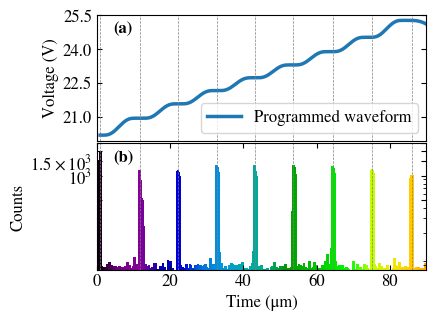

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from matplotlib.ticker import MaxNLocator

# Assuming you have your data loaded in real_data_resampled, data_resampled, binned_hist_index, binned_data
# and your half_column_width_inches, aspect_ratio, legend_fontsize are defined as well

# Create subplots with shared x-axis, slightly increased height for clarity
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(half_column_width_inches, 1.5 * (half_column_width_inches / aspect_ratio)))

# Plotting the first plot
axs[0].plot(data_resampled['Time (us)'] *0.86* 1e6, data_resampled['Value'] * (-0.0682 * 1e6) + 20.17, 'C0', linewidth=2.5, label='Programmed waveform')
axs[0].set_ylabel('Voltage (V)', fontdict={'family': 'STIXGeneral', 'size': 12})
axs[0].legend(fontsize=legend_fontsize)

# Move (a) inside the plot
axs[0].text(0.05, 0.95, '(a)', transform=axs[0].transAxes, size=12, weight='bold', va='top')

# Customize the first subplot's y-axis to have a fixed number of ticks
axs[0].yaxis.set_major_locator(MaxNLocator(5))

# Customize the first subplot's x-axis to hide labels and ticks
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plotting the second plot initially
axs[1].bar(binned_hist_index, binned_data, color='C0', width=0.02)

# Find peaks
peaks, properties = find_peaks(binned_data, prominence=1)  # Adjust prominence as needed
colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(peaks)))

for i, peak in enumerate(peaks):
    peak_area_indices = np.arange(max(0, peak-5), min(len(binned_data), peak+6))
    axs[1].bar(binned_hist_index[peak_area_indices], binned_data[peak_area_indices], color=colors[i], width=0.75)

axs[1].set_xlabel(r'Time (μm)', fontdict={'family': 'STIXGeneral', 'size': 12})
axs[1].set_ylabel('Counts', fontdict={'family': 'STIXGeneral', 'size': 12})

# Set the y-axis of the second plot to log scale
axs[1].set_yscale('log')

# Move (b) inside the plot
axs[1].text(0.05, 0.95, '(b)', transform=axs[1].transAxes, size=12, weight='bold', va='top')

# Customize the second subplot's y-axis to have a fixed number of ticks
axs[1].yaxis.set_major_locator(MaxNLocator(5))

# Adjust the ylim for the second plot as needed
ylim_min, ylim_max = 70, 2500  # Set your desired limits here
axs[1].set_ylim(ylim_min, ylim_max)

# Find peaks with adjusted parameters for better sensitivity
top_peaks = peaks[np.argsort(properties['prominences'])][-10:]  # Attempt to get the highest 9 peaks

# Add vertical dashed lines at each peak for both subplots
for peak in top_peaks:
    axs[0].axvline(x=binned_hist_index[peak], color='grey', linestyle='--', linewidth=0.5)
    axs[1].axvline(x=binned_hist_index[peak], color='grey', linestyle='--', linewidth=0.5)

plt.xlim(0, 90)
axs[0].grid(False)
axs[1].grid(False)
fig.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, hspace=0.02, wspace=0.2)
plt.savefig('Fig_2_simple_log.pdf', format='pdf', bbox_inches='tight')
plt.show()


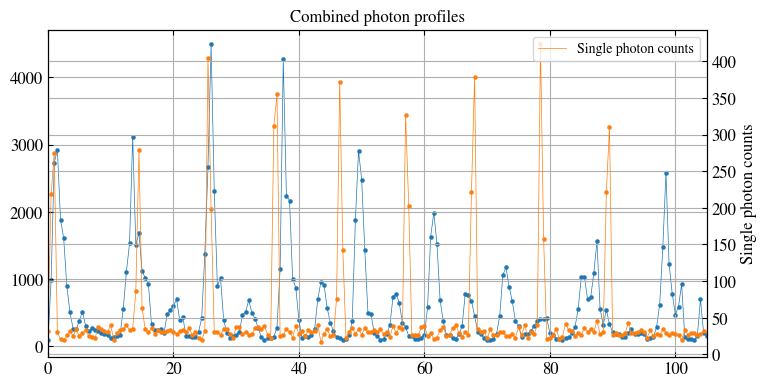

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Set the matplotlib parameters
matplotlib.rcParams.update(
    {"font.family": "STIXGeneral",
     "xtick.labelsize": 12,
     "xtick.direction": "in",
     "xtick.major.pad": 3,
     "xtick.top": True,
     "ytick.labelsize": 12,
     "ytick.direction": "in",
     "ytick.right": True,
     "axes.labelsize": 12,
     "axes.labelpad": 3,
     "axes.grid": True
    }
)

# Load the first dataset
path = "/Users/bingran.you/SynologyDrive/Multiplexing/Data Processing/Experimental_Data/Multiplexing/TimeTagger_Data"
file_name = "/Histogram_2024-01-14_152137.txt"
raw_data = np.loadtxt(path + file_name, delimiter='\t', dtype='str')
data = np.array(raw_data[1:]).astype(dtype="f").transpose()

time_bins = data[0, :] / 1e6
counts = data[1, :]

# Load the second dataset
hist_index = np.load("Single_photon_histogram_index.npy")
final_hist = np.load("Single_photon_histogram_data.npy")

# Plotting
half_column_width_inches = 4.25 * 2
aspect_ratio = 2
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
plt.rc('font', family='STIXGeneral')

# Plot the first dataset
plt.plot(time_bins, counts, c='C0', linewidth=0.5)
plt.scatter(time_bins, counts, c='C0', linewidths=0.1, s=10, label='Photon temporal profile')

# Create a second y-axis for the second dataset
ax2 = plt.twinx()
ax2.plot(hist_index, final_hist, c='C1', linewidth=0.5, label='Single photon counts')
ax2.scatter(hist_index, final_hist, c='C1', linewidths=0.1, s=10)

# Set titles and labels for the first y-axis
plt.title('Combined photon profiles', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time ($\mu$s)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel('Photon counts', fontdict={'family': 'STIXGeneral', 'size': 12})

# Set labels for the second y-axis
ax2.set_ylabel('Single photon counts', fontdict={'family': 'STIXGeneral', 'size': 12})

# Set labels for the second y-axis
ax2.set_ylabel('Single photon counts', fontdict={'family': 'STIXGeneral', 'size': 12})

# Set the x-axis limits
plt.xlim(0, 105)

# Enable grid only for the first y-axis
plt.grid(True)

# Add legends
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the figure with tight bounding box
pdf_filename = 'Combined_photon_profiles.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import re
import pandas as pd
import numpy as np

# Input data
data = """
range(0us, 5us)
0
range(5us, 15us)
k1 = 1.0
k2 = -1.5e5
k3 = 6.0e9
-8.729e-6 * 1.0e16*(k1*(t**3)+k2*(t**4)+k3*(t**5))
...
range(165us, 200us)
1.608 * t
"""

# Parse the input data
ranges = re.findall(r'range\((\d+)us, (\d+)us\)\n(.*?)(?=\nrange|\Z)', data, re.DOTALL)

# Sampling rate and number of points
sampling_rate = 5000000  # 5,000,000 samples per second
total_points = 1000
duration_us = 200  # Total duration in microseconds from the data

# Calculate interval for sampling
interval = duration_us / total_points

# Prepare dataframe for storing results
df = pd.DataFrame(columns=['Time (us)', 'Value'])

# Function to evaluate expression
def eval_expression(expr, t):
    k1, k2, k3 = 1.0, -1.5e5, 6.0e9  # Default values
    return eval(expr)

# Process each range
for start, end, expr in ranges:
    start, end = int(start), int(end)
    expr = expr.strip()
    
    if expr.isdigit() or (expr.startswith('-') and expr[1:].isdigit()):
        # Constant value
        value = float(expr)
        times = np.arange(start, end, interval)
        values = [value] * len(times)
    else:
        # Expression
        times = np.arange(start, end, interval)
        values = [eval_expression(expr, t) for t in times]

    # Append to dataframe
    temp_df = pd.DataFrame({'Time (us)': times, 'Value': values})
    df = pd.concat([df, temp_df])

# Reset index
df.reset_index(drop=True, inplace=True)

# Save to CSV
df.to_csv('output.csv', index=False)

/var/folders/d_/n_1tswj10tx48jnbz62dz3_00000gn/T/ipykernel_1986/375685272.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df])


SyntaxError: invalid syntax (<string>, line 1)

In [ ]:
np.average(ion_position[1:]-ion_position[:-1])

7.224754768351604

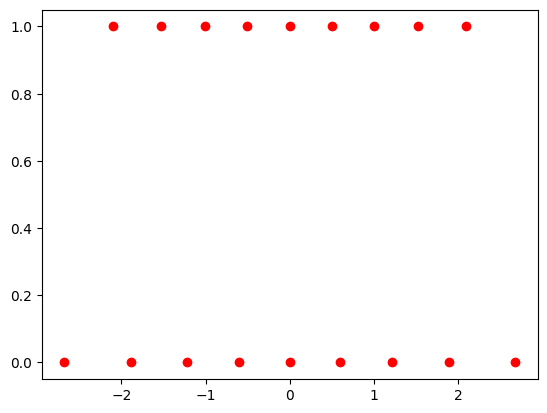

In [ ]:
plt.plot(quarticEqposition(9,1,0),np.zeros(9),"ro")
plt.plot(quarticEqposition(9,1,0.3),np.ones(9),"ro")

In [ ]:
N = 9
np.arange(-int(N/2),int(N/2)+1)

array([-4, -3, -2, -1,  0,  1,  2,  3,  4])

Okay, after we apply the Newton method and the result converges, much better than fsolve. I've checked the err is less that $10^{-6}$ for N = 300. This is finally resolved. Also see James paper for reference(https://arxiv.org/pdf/physics/9711023.pdf), he used the fourth order Runge-Kutta method to get the equiposition of N = 1000.
We make use of the "analytic" result as the guess function:

$\begin{aligned} u_{n} &=\sqrt{\frac{4 A}{3 B}} \cos \left(\frac{1}{3} \cos ^{-1}\left[-\sqrt{\frac{27 B}{4 A^{3}}}\left\{n-\frac{(N+1)}{2}\right\}\right]+\frac{4 \pi}{3}\right) \\ &=\alpha(N) \sin \left(\frac{1}{3} \sin ^{-1}\left[\beta(N)\left\{n-\frac{(N+1)}{2}\right\}\right]\right) \end{aligned}$

With $\alpha(N)=\sqrt{4 A / 3 B} \approx 3.94 N^{0.387}$, $\beta(N)=\sqrt{27 B / 4 A^{3}} \approx 1.75 N^{-0.982}$

Now we calculate the mode spectrum. The Lagrangian of the system is:

$\begin{align} L &= \frac{M}{2} \sum_{m=1}^{N}\left(\dot{q}_{m}\right)^{2}-\frac{1}{2} \sum_{n, m=1}^{N} q_{n} q_{m}\left[\frac{\partial^{2} V}{\partial x_{n} \partial x_{m}}\right]_{0}\\
 &= \frac{M}{2}\left[\sum_{m=1}^{N}\left(\dot{q}_{m}\right)^{2}-\omega^{2} \sum_{n, m=1}^{N} A_{n m} q_{n} q_{m}\right]\end{align}$

For the axialmodes:

$A_{n m}=\left\{\begin{array}{cll}1+2 \sum_{p=1}^{N} \frac{1}{\left|u_{m}-u_{p}\right|^{3}} & \text { if } & n=m \\ p \neq m & & \\ \frac{-2}{\left|u_{m}-u_{n}\right|^{3}} & \text { if } & n \neq m\end{array}\right.$

The modes are eigenvalues of this determinant.

Radialmodes we have:

$A_{m, n}^{x, y}=\left(\left(\frac{\omega_{x, y}}{\omega_{z}}\right)^{2}+\frac{1}{2}\right) \delta_{m, n}-\frac{1}{2} A_{m, n}^{z}$

And the coupling between axial and radial terms would zero. 

In [ ]:
def EqualAxialfull(N, wz): # N is the ion number, wz is the axial frequency, in MHz
    t0 =time()
    #u=np.arange(-int(N/2),int(N/2)+1)
    u=np.array([-2.0,-1.0,-0.2,0.2,1.0,2.0])
    u_1=np.empty(shape=(N))
    for i in range(N):
        u_1[i]= np.sum(1/np.absolute(u[i]-u[:i])**3) + np.sum(1/np.absolute(u[i]-u[i+1:])**3)
    A=np.empty((N,N))
    for i in range(N):
        for j in range(N):
            if j==i:
                A[i,j]=1+2*u_1[i] # A_mn, m==n
            else:
                A[i,j]=-2/np.absolute(u[i]-u[j])**3 #A_mn, m!=n
    print (time()-t0)
    w,v = np.linalg.eig(A)
    idx = np.argsort(w)
    w = w[idx]
    v = v[:,idx]
    return ([w,v])
    
def EqualAxialmodes(N, wz):
    t0 =time()
    return(np.sqrt(EqualAxialfull(N, wz)[0])*wz)

In [ ]:
np.arange(-int(N/2),int(N/2)+1)

array([-4, -3, -2, -1,  0,  1,  2,  3,  4])

In [ ]:
Axialmodes(3, 1)

NameError: name 'Axialmodes' is not defined

0.0013499259948730469


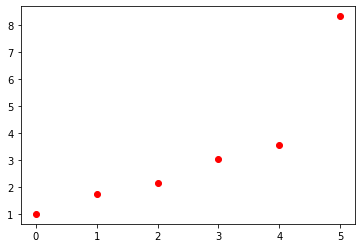

In [ ]:
plt.plot(np.arange(6),EqualAxialmodes(6,1),"ro")

In [ ]:
def Axialfull(N, wz): # N is the ion number, wz is the axial frequency, in MHz
    t0 =time()
    u=Eqposition3(N)
    u_1=np.empty(shape=(N))
    for i in range(N):
        u_1[i]= np.sum(1/np.absolute(u[i]-u[:i])**3) + np.sum(1/np.absolute(u[i]-u[i+1:])**3)
    A=np.empty((N,N))
    for i in range(N):
        for j in range(N):
            if j==i:
                A[i,j]=1+2*u_1[i] # A_mn, m==n
            else:
                A[i,j]=-2/np.absolute(u[i]-u[j])**3 #A_mn, m!=n
    print (time()-t0)
    w,v = np.linalg.eig(A)
    idx = np.argsort(w)
    w = w[idx]
    v = v[:,idx]
    return ([w,v])
    
def Axialmodes(N, wz):
    t0 =time()
    return(np.sqrt(Axialfull(N, wz)[0])*wz)

0.009950876235961914
0.009994983673095703
0.009768009185791016
0.009670257568359375


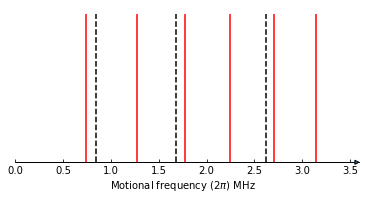

In [ ]:
N = 6
w_z =0.735
fig = plt.figure(figsize=(6,3))
ax = SubplotZero(fig, 111)
fig.add_subplot(ax)

for direction in ["xzero"]:
    # adds arrows at the ends of each axis
    ax.axis[direction].set_axisline_style("-|>")

    # adds X and Y-axis from the origin
    ax.axis[direction].set_visible(True)

for direction in ["left", "right", "bottom", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)
    
plt.xticks(fontsize= 16)
plt.xlabel("Motional frequency $(2\pi)$ MHz",fontsize=16)
ax.vlines(Axialmodes(N, w_z),ymin=0,ymax=1,colors='r')
ax.vlines(np.array([Axialmodes(N,w_z)[0]+0.1076,Axialmodes(N,w_z)[2]-0.098,Axialmodes(N,w_z)[4]-0.0756]),ymin=0,ymax=1,linestyles='dashed')
plt.xlim([0, 3.5])
plt.savefig("6_ion_spectrum.pdf",dpi = 300, format = "pdf")

In [ ]:
Axialfull(N,w_z)[1][0]

0.034407854080200195


array([[ 0.40824829, -0.60799974,  0.55312194,  0.35767765, -0.1654976 ,
         0.04902059],
       [ 0.40824829, -0.34328364, -0.13323584, -0.54304818,  0.56176645,
        -0.2953896 ],
       [ 0.40824829, -0.11177055, -0.41988609, -0.27778657, -0.39626885,
         0.6405794 ],
       [ 0.40824829,  0.11177055, -0.41988609,  0.27778657, -0.39626885,
        -0.6405794 ],
       [ 0.40824829,  0.34328364, -0.13323584,  0.54304818,  0.56176645,
         0.2953896 ],
       [ 0.40824829,  0.60799974,  0.55312194, -0.35767765, -0.1654976 ,
        -0.04902059]])

0.0251009464263916
0.011413097381591797
0.012363910675048828
0.025614023208618164
0.013534069061279297
0.012993097305297852
0.010132074356079102
0.010584831237792969
0.01131892204284668
0.009869098663330078
0.010106801986694336
0.009586095809936523
0.009792089462280273
0.009981870651245117
0.009947061538696289
0.009966850280761719
0.010329008102416992
0.010116100311279297


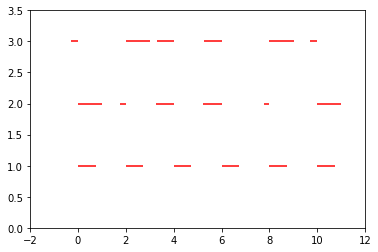

In [ ]:
for i in range(6):
    plt.hlines(y=1,xmin =2*i,  xmax =2*i+1.8*Axialfull(N,w_z)[1][i,0], color= 'r')
    plt.hlines(y=2,xmin =2*i,  xmax =2*i+1.8*Axialfull(N,w_z)[1][i,2], color= 'r')
    plt.hlines(y=3,xmin =2*i,  xmax =2*i+1.8*Axialfull(N,w_z)[1][i,4], color= 'r')
plt.xlim(-2,12)
plt.ylim(0,3.5) 
# Showing the graph
plt.savefig("6_ion_mode.pdf",dpi = 300, format = "pdf")

0.022644996643066406


TypeError: object of type 'int' has no len()

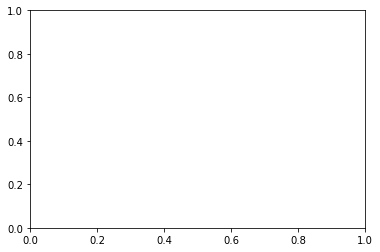

In [ ]:
plt.hlines(1,0,  1.6*Axialfull(N,w_z)[1][0,0], 0,color= 'r')

0.024076223373413086


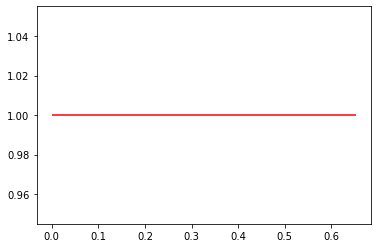

In [ ]:
plt.hlines(y=1,xmin =0,  xmax =0+1.6*Axialfull(N,w_z)[1][0,0], color= 'r')

In [ ]:
quarticAxialfull(5, 0.7)

0.031893014907836914


[array([ 1.        ,  2.6249828 ,  6.57240122, 13.22395832, 13.54545605]),
 array([[-4.47213595e-01, -5.46411059e-01,  3.52339053e-01,
         -4.48815056e-01,  4.19353302e-01],
        [-4.47213595e-01, -4.48815056e-01,  7.76747947e-02,
          5.46411059e-01, -5.42186892e-01],
        [-4.47213595e-01, -2.28401029e-16, -8.60027695e-01,
         -2.30199518e-15,  2.45667181e-01],
        [-4.47213595e-01,  4.48815056e-01,  7.76747947e-02,
         -5.46411059e-01, -5.42186892e-01],
        [-4.47213595e-01,  5.46411059e-01,  3.52339053e-01,
          4.48815056e-01,  4.19353302e-01]])]

In [ ]:
Axialfull(5, 0.7)

0.01728987693786621


[array([ 1.        ,  3.00001005,  5.81773003,  9.33220041, 13.4748815 ]),
 array([[ 4.47213595e-01, -6.39532601e-01, -5.37653433e-01,
         -3.01658834e-01,  1.04540835e-01],
        [ 4.47213595e-01, -3.01658834e-01,  2.80515484e-01,
          6.39532601e-01, -4.70437098e-01],
        [ 4.47213595e-01, -1.63067741e-16,  5.14275898e-01,
         -5.42110034e-16,  7.31792526e-01],
        [ 4.47213595e-01,  3.01658834e-01,  2.80515484e-01,
         -6.39532601e-01, -4.70437098e-01],
        [ 4.47213595e-01,  6.39532601e-01, -5.37653433e-01,
          3.01658834e-01,  1.04540835e-01]])]

In [ ]:
def quarticAxialfull(N, wz): # N is the ion number, wz is the axial frequency, in MHz
    t0 =time()
    u=quarticEqposition(N,-1.5,1)
    u_1=np.empty(shape=(N))
    for i in range(N):
        u_1[i]= np.sum(1/np.absolute(u[i]-u[:i])**3) + np.sum(1/np.absolute(u[i]-u[i+1:])**3)
    A=np.empty((N,N))
    for i in range(N):
        for j in range(N):
            if j==i:
                A[i,j]=1+2*u_1[i] # A_mn, m==n
            else:
                A[i,j]=-2/np.absolute(u[i]-u[j])**3 #A_mn, m!=n
    print (time()-t0)
    w,v = np.linalg.eig(A)
    idx = np.argsort(w)
    w = w[idx]
    v = v[:,idx]
    return ([w,v])
    
def quarticAxialmodes(N, wz):
    t0 =time()
    return(np.sqrt(quarticAxialfull(N, wz)[0])*wz)

In [ ]:
def Radialfull(N, wz, wx): #  N is the ion number, wz is the axial frequency, wx is the radial frequency, in MHz
    u=Eqposition3(N)
    u_1=np.empty(shape=(N))
    for i in range(N):
        u_1[i]= np.sum(1/np.absolute(u[i]-u[:i])**3) + np.sum(1/np.absolute(u[i]-u[i+1:])**3)
    
    A=np.empty((N,N))
    for i in range(N):
        for j in range(N):
            if j==i:
                A[i,j]=(wx/wz)**2-u_1[i] # A_mn, m==n
            else:
                A[i,j]=1/np.absolute(u[i]-u[j])**3 # A_mn, m!=n
    
    w,v = np.linalg.eig(A)
    idx = np.argsort(w)
    w = w[idx]
    v = v[:,idx]
    return ([w,v])

def Radialmodes(N, wz, wx):
    return np.sqrt(Radialfull(N, wz, wx)[0])*wz

In [ ]:
Radialmodes(9, 0.18, 1)

array([0.65607959, 0.73133469, 0.79422635, 0.84730436, 0.89209129,
       0.92950662, 0.96001557, 0.98366663, 1.        ])

In [ ]:
#L-D parameter matrix 
def eta(N, wz, wx):
    t0 = time()
    A = Radialfull(N,wz,wx)
    eta = np.zeros((N,N))
    for i in range(N):
        eta[i] = 2*np.pi*np.sqrt(2)/(313.3e-9)*np.sqrt(1.0545718e-34/(2*9*1.66054e-27*2*np.pi*np.sqrt(A[0])*wz*1e6)) *  np.transpose(A[1])[:,i]
    #print(time()-t0)
    return eta

In [ ]:
def etaYb(N, wz, wx):
    t0 = time()
    A = Radialfull(N,wz,wx)
    eta = np.zeros((N,N))
    for i in range(N):
        eta[i] = 2*np.pi*np.sqrt(2)/(355)*np.sqrt(1.0545718e-34/(2*171*1.66054e-27*2*np.pi*np.sqrt(A[0])*wz*1e6)) *  np.transpose(A[1])[:,i]
    #print(time()-t0)
    return eta

In [ ]:
def EqualAxialfull(N, wz): # N is the ion number, wz is the axial frequency, in MHz
    t0 =time()
    #u=np.arange(-int(N/2),int(N/2)+1)
    u=np.array([-1.7429, -0.8121, -0.05    ,  0.8221,  1.7529])
    u_1=np.empty(shape=(N))
    for i in range(N):
        u_1[i]= np.sum(1/np.absolute(u[i]-u[:i])**3) + np.sum(1/np.absolute(u[i]-u[i+1:])**3)
    A=np.empty((N,N))
    for i in range(N):
        for j in range(N):
            if j==i:
                A[i,j]=1+2*u_1[i] # A_mn, m==n
            else:
                A[i,j]=-2/np.absolute(u[i]-u[j])**3 #A_mn, m!=n
    print (time()-t0)
    w,v = np.linalg.eig(A)
    idx = np.argsort(w)
    w = w[idx]
    v = v[:,idx]
    return ([w,v])
    
def EqualAxialmodes(N, wz):
    t0 =time()
    return(np.sqrt(EqualAxialfull(N, wz)[0])*wz)

In [ ]:
EqualAxialmodes(5, 1)[1:]-EqualAxialmodes(5, 1)[:-1]

0.0
0.0


array([0.72485938, 0.66654341, 0.62110005, 0.75710251])

In [ ]:
l=((1.6e-19)**2*9e9/(40*1.66e-27*(2*np.pi*0.246e6)**2))**(1/3)*1e6 #wz = 0.15e6, axial freq 

In [ ]:
Eqposition3(10)*l

array([-32.51139646, -23.78228871, -16.42517293,  -9.66883447,
        -3.19470848,   3.19470848,   9.66883447,  16.42517293,
        23.78228871,  32.51139646])

In [ ]:
EqualAxialfull(5, 1)

0.0


[array([ 1.81670433,  7.18051144, 13.42079176, 20.01011587, 23.15078371]),
 array([[-0.58789997, -0.46869188, -0.45394826, -0.17141799,  0.44637249],
        [-0.55497007, -0.22363959,  0.11956711,  0.20619599, -0.7649709 ],
        [-0.47519898,  0.24850626,  0.72464421,  0.11662779,  0.41679647],
        [-0.30866846,  0.67280832, -0.23631662, -0.60525352, -0.17284496],
        [-0.1590332 ,  0.46463626, -0.44573525,  0.74038181,  0.10943696]])]

In [ ]:
Axialmodes(4, 1)[1:]-Axialmodes(4, 1)[:-1]

0.006005287170410156
0.005004167556762695


array([0.73205274, 0.6783359 , 0.64057105])

0.007006406784057617


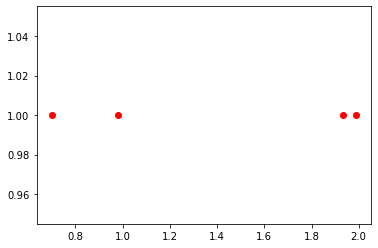

In [ ]:
plt.plot(quarticAxialmodes(3, 0.7),np.ones(4),"ro")

In [ ]:
Radialmodes(45,0.15,2.5)

C:\Users\Bobby\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


array([       nan,        nan, 0.35096567, 0.60535921, 0.7781653 ,
       0.91667666, 1.0348341 , 1.13898924, 1.23257022, 1.31793294,
       1.39653587, 1.46944337, 1.53747608, 1.60123832, 1.66120739,
       1.71776153, 1.77124751, 1.82189464, 1.86995064, 1.91557453,
       1.95892858, 2.00016731, 2.03938878, 2.07670318, 2.11218933,
       2.1459336 , 2.17800589, 2.20845745, 2.23734071, 2.26469508,
       2.29055469, 2.31495368, 2.33791629, 2.35946313, 2.37960292,
       2.398342  , 2.41567939, 2.43160734, 2.44610879, 2.45915399,
       2.47069907, 2.48067663, 2.48898914, 2.49549594, 2.5       ])

Ising model with a transverse field:

$H=\sum_{i<j} J_{i, j} \sigma_{x}^{(i)} \sigma_{x}^{(j)}+B_{x} \sum_{i} \sigma_{x}^{(i)}+B_{y}(t) \sum_{i} \sigma_{y}^{(i)}$

$J_{i, j}$ is given by M-S interaction, $B_x$ and $B_y(t)$ are generated by a pair of Raman beams driving the carrier transition


Now calculate the Ising interaction.

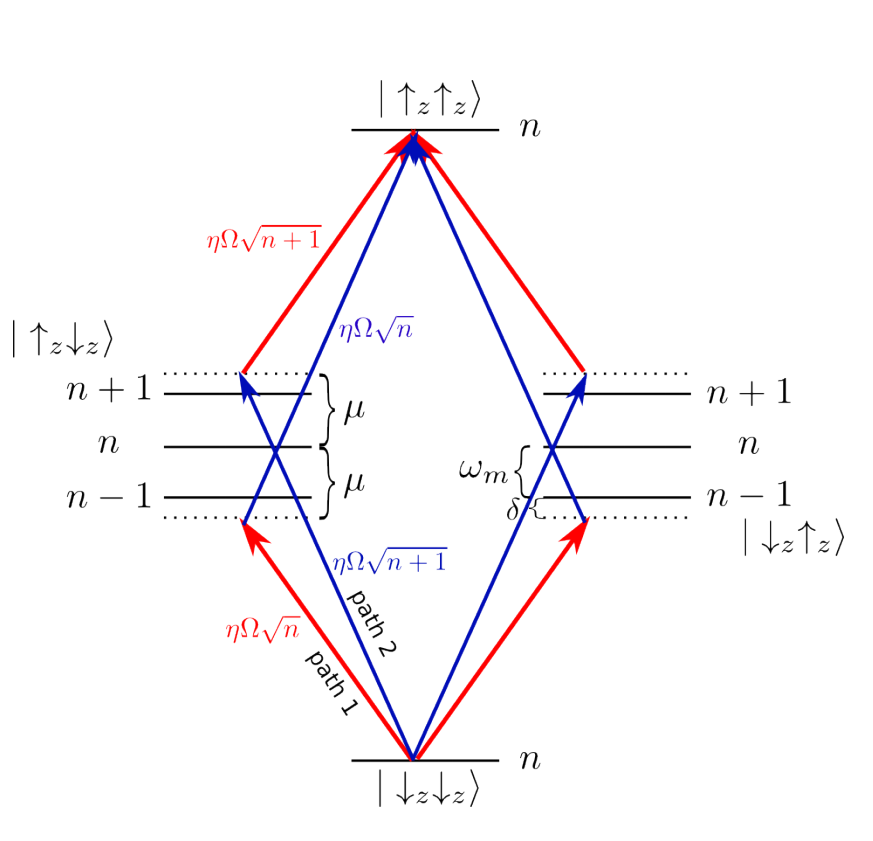

General M-S interaction for N ions:

$H_{M S}=-\sum_{i, m} \eta_{i, m} \Omega_{i} \sin (\mu t) \sigma_{i}^{x}\left(a_{m} e^{-i \omega_{m} t}+a_{m}^{\dagger} e^{i \omega_{m} t}\right)$

Use Magnus expansion we have the evolution operator:

$U(t)=T\left[e^{-i \int_{0}^{t} d t_{1} H\left(t_{1}\right)}\right]=e^{\bar{\Omega}_{1}+\bar{\Omega}_{2}+\bar{\Omega}_{3}+\cdots}$

Rewrite U with the M-S Hamiltonian:

$U(\tau)=\exp \left[\sum_{i} \hat{\phi}_{i} \sigma_{x}^{(i)}+i \sum_{i, j} \chi_{i, j}(\tau) \sigma_{x}^{(i)} \sigma_{x}^{(j)}\right]$

Higher order terms would be zero. 

$\hat{\phi}_{i}(\tau)=\sum_{m}\left[\alpha_{i, m}(\tau) a_{m}^{\dagger}-\alpha_{i, m}^{*}(\tau) a_{m}\right]$ represents spin-dependent displacements of the mth motional modes through phase
space by an amount:

$\alpha_{i, m}(\tau)=\frac{-i \eta_{i, m} \Omega_{i}}{\mu^{2}-\omega_{m}^{2}}\left[\mu-e^{i \omega_{m} \tau}\left(\mu \cos \mu \tau-i \omega_{m} \sin \mu \tau\right)\right]$

This would introduce unwanted spin flip which is the source of phonon err.

The second term:

$\chi_{i, j}(\tau)=\Omega_{i} \Omega_{j} \sum_{m} \frac{\eta_{i, m} \eta_{j, m}}{\mu^{2}-\omega_{m}^{2}}\left[\frac{\mu \sin \left(\mu-\omega_{m}\right) \tau}{\mu-\omega_{m}}-\frac{\mu \sin \left(\mu+\omega_{m}\right) \tau}{\mu+\omega_{m}}+\frac{\omega_{m} \sin 2 \mu \tau}{2 \mu}-\omega_{m} \tau\right]$


In the slow regime this can be simplified to:



$\begin{align}J_{i, j} &=\Omega_{i} \Omega_{j} \frac{\hbar(\Delta k)^{2}}{2 M} \sum_{m} \frac{b_{i, m} b_{j, m}}{\mu^{2}-\omega_{m}^{2}}\\
&= \sum_{n=1}^{N} \Omega_{i, n} \Omega_{j, n} \sum_{m=1}^{N} \frac{\eta_{i, m} \eta_{j, m} \omega_{m}}{\mu_{n}^{2}-\omega_{m}^{2}}
\end{align}$

This is just for the radialmodes, because the axialmodes are seperated, I don't think the approximation here $\omega \gg \delta \gg \eta\Omega $ would work. 

For simplification here we assume  Raman beam $\lambda$ = 313.3 nm, for Be+


In [ ]:
def Jij_x(i, j, N, wr, wb, wz, wx, mu): 
    t0 = time()
    # Radial Ising interaction between the i and j ion, total ion number N
    # wr,wb are RSB and BSB beam carrier frequency
    # wz,wz are axial and radial trap frequency
    # Detuning from carrier mu
    # All in MHz
    sum = 0
    A = Radialmodes(N, wz, wx)
    eta_1 = eta(N, wz, wx)
        #sum+= np.transpose(A[1])[m][i] * np.transpose(A[1])[m][j]/(mu**2-A[0][m]*(wz**2))
    sum = np.sum(eta_1[i]*eta_1[j]*A[:]/(mu**2-A[:]**2))
    if i != j:
        #return sum*wr*wb*1.0545718e-34 *(2*np.pi*np.sqrt(2)/(313.3e-9))**2/(2*9*1.66054e-27)/(2*np.pi*1000) 
        return sum *1000
    else: 
        return 0
# Yb lambda= 355 nm, mass= 171 amu

def FullJij(N, wr, wb, wz, wx ,mu): # Jij matrix
    t0 = time()
    A= np.zeros((N,N))
    sum = 0
    B = Radialmodes(N, wz, wx)
    eta_1 = eta(N, wz, wx)
    
    for i in range(N):
        for j in range(N):
            if i!=j:
                Jij = np.sum(eta_1[i]*eta_1[j]*B[:]/(mu**2-B[:]**2))* 1000
                A[i][j] = Jij
    #print(time()-t0)
    return A

# output in kHz #

# Calculating the full matrix can be easily improved using the symmerty #

In [ ]:
#fitting the interaction range alpha
def Jij_average(N, wr, wb, wz, wx ,mu): # Average of Jij for each |i-j|
    A = FullJij(N,wr, wb, wz, wx ,mu)
    B = []
    for i in range(1,N):
        sum = 0
        for j in range(N-i):
            sum += A[j][j+i]
        B.append(sum/(N-i))
    return B

def Jijfit(N, wr, wb, wz, wx ,mu): # fitting function
    def fitfunc(x,a,b):
        return a/(x**b)
    xdata = np.arange(1,N,1) # fitting data
    ydata = Jij_average(N, wr, wb, wz, wx ,mu)
    popt, pcov = curve_fit(fitfunc, xdata, ydata)
    plt.plot(xdata,ydata,'ro', label='data') #plot data and fit
    plt.plot(np.arange(1,N,0.3), fitfunc(np.arange(1,N,0.3), *popt), 'g--', label=r'fit: $\alpha$ = %5.3f' % tuple(popt)[1])
    plt.xlabel('|i-j|')
    plt.ylabel(r'|$J_{ij}$| (KHz)')
    plt.legend()
    plt.show()
    
    

The spin-dependent displacements of the mth motional modes through phase space by an amount:

$\alpha_{i, m}(\tau)=\frac{i \eta_{i, m} \Omega_{i}}{\mu^{2}-\omega_{m}^{2}}\left[\mu-e^{i \omega_{m} \tau}\left(\mu \cos \mu \tau-i \omega_{m} \sin \mu \tau\right)\right]$

Consider a single spin flip: 

We initialise at |$\uparrow_{z}$>, with ground state cooling. Under the time evolution:

$e^{\bar{\Omega}_{1}}$|$\uparrow_{z}$>|0> = $\downarrow_{z}$>|0> 



In [ ]:
# spin dependent displacement
def alpha_im(w, i,m, N, wz,wx, mu, t): # alpha amplitude on the ith ion, mth mode. i,m start from 0
    A = Radialfull(N,wz,wx)
    # L-D parameter
    eta_im = 2*np.pi*np.sqrt(2)/(313.3e-9)*np.sqrt(1.0545718e-34/(2*9*1.66054e-27*2*np.pi*np.sqrt(A[0][m])*wz*1e6)) * np.transpose(A[1])[m][i]
    a = 1j * w * eta_im  /(mu**2-A[0][m]*(wz**2)) * (mu-np.exp(np.sqrt(A[0][m])*wz*t*1j)*(mu*np.cos(mu*t)-1j*np.sqrt(A[0][m])*wz*np.sin(mu*t)))/(mu**2-A[0][m]*(wz**2))
    return a


def alpha_sum_m(w, i, N, wz, wx, mu,t):
    sum=0
    for m in range(N): 
        sum += np.absolute(alpha_im(w, i, m, N, wz, wx, mu, t))**2
    return sum


def alpha_sum_im(w, N, wz, wx, mu,t):
    sum=0
    for m in range(N): 
        for i in range(N): 
            sum += alpha_im(w, i, m, N, wz, wx, mu, t)
    return np.absolute(sum)**2




In [ ]:
    N = 2
    Jij = FullJij(N,1,1,0.15,6,6.3)
    H_Ising = 0 
    sx_list = []
    sy_list = []
    sz_list = []
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(qeye(2))
            
        op_list[n] = sigmax()
        sx_list.append((tensor(op_list)))
        
        op_list[n] = sigmay()
        sy_list.append((tensor(op_list)))
        
        op_list[n] = sigmaz()
        sz_list.append((tensor(op_list)))
    for i in range(N):
        for j in range(N):
            H_Ising += 1/2 * Jij[i][j] * sx_list[i] * sx_list[j] 
    psi_list = []
    for n in range(N):
        psi_list.append(basis(2,int((1+(-1)**n)/2))) #Neel order spin 
        #psi_list.append(basis(2,0))
    psi0 = tensor(psi_list)
    tlist = 2*np.pi*np.linspace(0, 5, 200)
    result = mesolve(H_Ising, psi0, tlist)
    

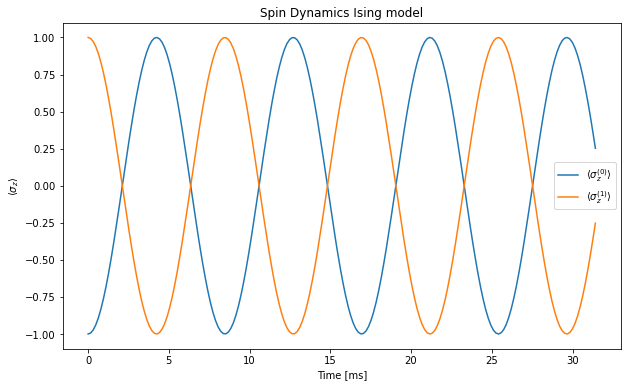

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in range(N):
    ax.plot(tlist, expect(sz_list[n], result.states), label=r'$\langle \sigma_z^{(%d)} \rangle$'%n)

ax.legend(loc=0)
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'$\langle \sigma_z \rangle$')
ax.set_title(r'Spin Dynamics Ising model');

In [ ]:
    mu = 6.1
    N=2
    n_phonon = 3
    sx_list = []
    sy_list = []
    sz_list = []
    am = destroy(n_phonon)
    am_list = []
    
    # spin and phonon identity operators, seperate Hilbert space
    op_list = []
    for m in range(N):
        op_list.append(qeye(2))
    spin_id = tensor(op_list)
    
    
    op_list = []
    for m in range(N):
        op_list.append(qeye(n_phonon))
    phonon_id = tensor(op_list)
    
    # spin x, y, and z operators, full Hilbert space, pure spins
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(qeye(2))
            
        op_list[n] = sigmax()
        sx_list.append(tensor(tensor(op_list),phonon_id))
        
        op_list[n] = sigmay()
        sy_list.append(tensor(tensor(op_list),phonon_id))
        
        op_list[n] = sigmaz()
        sz_list.append(tensor(tensor(op_list),phonon_id))
        
    # phonon operators, full hilbert space
    for m in range(N):
        op_list = []
        for n in range(N):
            op_list.append(qeye(n_phonon))
            
        op_list[m] = am
        am_list.append(tensor(spin_id,tensor(op_list)))
     
    #return sx_list[-1]*am_list[-1]
    A= Radialmodes(N,0.15,6)
    # now let's define some time-dependence
    H = []
    for m in range(N):
        def H1_coeff(t, args):
            return np.sin(mu*t)*np.exp(-(1j*t*A[m]))
        def H2_coeff(t, args):
            return np.sin(mu*t)*np.exp((1j*t*A[m]))
        
        for i in range(N):
            H1 = eta(N,0.15,6)[i][m]*sx_list[i]*am_list[m]
            H2 = eta(N,0.15,6)[i][m]*sx_list[i]*am_list[m].dag()
            H += [[H1,H1_coeff],[H2,H2_coeff]]
    
    tlist = 2*np.pi*np.linspace(0, 15, 1000)
    psi_list = []
    for n in range(N):
        psi_list.append(basis(2,int((1+(-1)**n)/2))) #Neel order spin 
    for n in range(N):
        psi_list.append(basis(n_phonon,0)) # phonon state
    psi0 = tensor(psi_list)

    result = mesolve(H, psi0, tlist)

test

In [ ]:
mu = 6.5
def fullSolve(N, n_phonon, delta_list, psi0, tlist):
    # NOTE: for now I've omitted the differences in the lamb-Dicke parameters, and set eta*Omega == 1 for all modes
    #eta_list, Bz, psi0, tlist, gamma, solver
#def checkOperators(N, n_phonon):   
#def checkHamiltonian (N, n_phonon, delta_list):
    # set up operators
    A = Radialmodes(N,0.15,6)
    sx_list = []
    sy_list = []
    sz_list = []
    am = destroy(n_phonon)
    am_list = []
    
    # spin and phonon identity operators, seperate Hilbert space
    op_list = []
    for m in range(N):
        op_list.append(qeye(2))
    spin_id = tensor(op_list)
    
    
    op_list = []
    for m in range(N):
        op_list.append(qeye(n_phonon))
    phonon_id = tensor(op_list)
    
    # spin x, y, and z operators, full Hilbert space, pure spins
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(qeye(2))
            
        op_list[n] = sigmax()
        sx_list.append(tensor(tensor(op_list),phonon_id))
        
        op_list[n] = sigmay()
        sy_list.append(tensor(tensor(op_list),phonon_id))
        
        op_list[n] = sigmaz()
        sz_list.append(tensor(tensor(op_list),phonon_id))
        
    # phonon operators, full hilbert space
    for m in range(N):
        op_list = []
        for n in range(N):
            op_list.append(qeye(n_phonon))
            
        op_list[m] = am
        am_list.append(tensor(spin_id,tensor(op_list)))
     
    #return sx_list[-1]*am_list[-1]
    
    # now let's define some time-dependence
    H = []
    for m in range(N):
        def H1_coeff(t, args):
            return 1j * np.exp(-(1j*t*(A[m]-mu)))
        def H2_coeff(t, args):
            return 1j * np.exp((1j*t*(A[m]-mu)))
        
        for i in range(N):
            H1 = eta(N,0.15,6)[i][m]*sx_list[i]*am_list[m]
            H2 = eta(N,0.15,6)[i][m]*sx_list[i]*am_list[m].dag()
            H += [[H1,H1_coeff],[H2,H2_coeff]]
            #H += [H2,H2_coeff]
    
    #return H
    
    result = mesolve(H, psi0, tlist)
    return result

In [ ]:
def fullSolve(N, n_phonon, delta_list, psi0, tlist):
    # NOTE: for now I've omitted the differences in the lamb-Dicke parameters, and set eta*Omega == 1 for all modes
    #eta_list, Bz, psi0, tlist, gamma, solver
#def checkOperators(N, n_phonon):   
#def checkHamiltonian (N, n_phonon, delta_list):
    # set up operators
    sx_list = []
    sy_list = []
    sz_list = []
    am = destroy(n_phonon)
    am_list = []
    
    # spin and phonon identity operators, seperate Hilbert space
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(qeye(2))
    spin_id = tensor(op_list)
    
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(qeye(n_phonon))
    phonon_id = tensor(op_list)
    
    # spin x, y, and z operators, full Hilbert space
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(qeye(2))
            
        op_list[n] = sigmax()
        sx_list.append(tensor(tensor(op_list),phonon_id))
        
        op_list[n] = sigmay()
        sy_list.append(tensor(tensor(op_list),phonon_id))
        
        op_list[n] = sigmax()
        sy_list.append(tensor(tensor(op_list),phonon_id))
        
    # phonon operators, full hilbert space
    for m in range(N):
        op_list = []
        for n in range(N):
            op_list.append(qeye(n_phonon))
            
        op_list[m] = am
        am_list.append(tensor(spin_id,tensor(op_list)))
     
    #return sx_list[-1]*am_list[-1]
    
    # now let's define some time-dependence
    H = []
    for m in range(N):
        def H1_coeff(t, args):
            return np.exp(-(1j*t*delta_list[m]))
        def H2_coeff(t, args):
            return np.exp((1j*t*delta_list[m]))
        
        for n in range(N):
            H1 =  sx_list[n]*am_list[m]
            H2 =  sx_list[n]*am_list[m].dag()
            H += [[H1,H1_coeff],[H2,H2_coeff]]
#            H += [H2,H2_coeff]
            
    #return H
    
    result = mesolve(H, psi0, tlist)
    return result


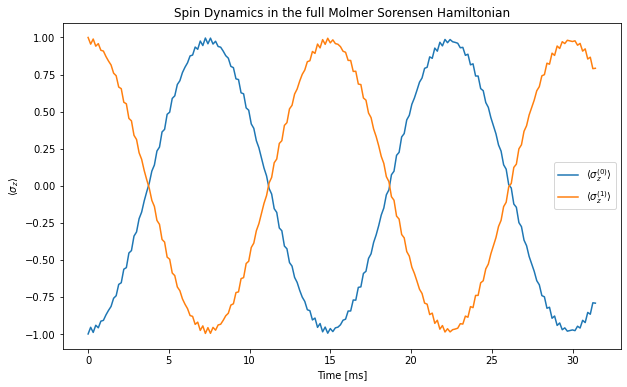

In [ ]:
N = 2
n_phonon = 3
# initial state, Neel order spin state, set all phonons to zero
psi_list = []
for n in range(N):
    psi_list.append(basis(2,int((1+(-1)**n)/2))) #Neel order spin 
for n in range(N):
    psi_list.append(basis(n_phonon,0)) # phonon state
psi0 = tensor(psi_list)

# detuning, this should come from the normal mode frequencies and laser frequency differences
delta_list = []
for n in range(N):
    delta_list.append(20.-n)

tlist = 2*np.pi*np.linspace(0, 5, 200)  
result = fullSolve(N,n_phonon, delta_list, psi0, tlist)

# set up spin operator in the full Hilbert space
sz_list = []
op_list = []
for n in range(N):
    op_list.append(qeye(n_phonon))
phonon_id = tensor(op_list)
for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(qeye(2))
    op_list[n] = sigmaz()
    sz_list.append(tensor(tensor(op_list),phonon_id)) #sz_list[n] the nth ion spin in the z basis  
    
# Plot spin excitations.
fig, ax = plt.subplots(figsize=(10,6))

for n in range(N):
    ax.plot(tlist, expect(sz_list[n], result.states), label=r'$\langle\sigma_z^{(%d)}\rangle$'%n)

ax.legend(loc=0)
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'$\langle\sigma_z\rangle $')
ax.set_title(r'Spin Dynamics in the full Molmer Sorensen Hamiltonian');

# Examples

In [ ]:
Eqposition3(300)

[-15.44301 -15.05427 -14.74452 -14.47569 -14.23327 -14.00982 -13.8009
 -13.60359 -13.41583 -13.23613 -13.06335 -12.8966  -12.73516 -12.57845
 -12.426   -12.27739 -12.13227 -11.99036 -11.8514  -11.71516 -11.58145
 -11.45009 -11.32092 -11.19381 -11.06863 -10.94526 -10.82361 -10.70358
 -10.58508 -10.46804 -10.35238 -10.23804 -10.12495 -10.01307  -9.90232
  -9.79267  -9.68407  -9.57647  -9.46984  -9.36413  -9.25931  -9.15535
  -9.05222  -8.94988  -8.84831  -8.74747  -8.64736  -8.54793  -8.44917
  -8.35105  -8.25356  -8.15667  -8.06037  -7.96464  -7.86945  -7.7748
  -7.68067  -7.58704  -7.49389  -7.40122  -7.30902  -7.21725  -7.12593
  -7.03502  -6.94453  -6.85443  -6.76473  -6.6754   -6.58645  -6.49785
  -6.4096   -6.32169  -6.23411  -6.14686  -6.05992  -5.97329  -5.88695
  -5.80091  -5.71515  -5.62967  -5.54446  -5.45951  -5.37482  -5.29037
  -5.20617  -5.12221  -5.03848  -4.95498  -4.87169  -4.78863  -4.70577
  -4.62311  -4.54065  -4.45839  -4.37631  -4.29442  -4.21271  -4.13117
  -4.049

In [ ]:
l=((1.6e-19)**2*9e9/(40*1.66e-27*(2*np.pi*0.25e6)**2))**(1/3)*1e6

In [ ]:
(1.6e-19)**2*9e9/(40*1.66e-27*(200*10**(-6))**3*(2*np.pi*3*10**6))/(2*np.pi)

3.662211456951968

In [ ]:
l

11.203615965389476

In [ ]:
N = 20
distance = Eqposition(N)[1:]-Eqposition(N)[:-1]
np.std(distance)/np.average(distance)

0.18575499784743466

In [ ]:
N = 20
distance_quartic = quarticEqposition(N,-1,1)[1:]-quarticEqposition(N,-1,1)[:-1]
np.std(distance_quartic)/np.average(distance_quartic)

0.0585536740104646

In [ ]:
distance_quartic

array([0.32462, 0.28612, 0.27283, 0.26969, 0.27214, 0.278  , 0.2856 ,
       0.2932 , 0.29888, 0.301  , 0.29888, 0.2932 , 0.2856 , 0.278  ,
       0.27214, 0.26969, 0.27283, 0.28612, 0.32462])

The following plot gives the equilibrium positions of the ions. Note that the length unit $l=(\frac{ e^{2}}{4 \pi \epsilon_{0} M \omega_z^{2}})^{1/3}$
 

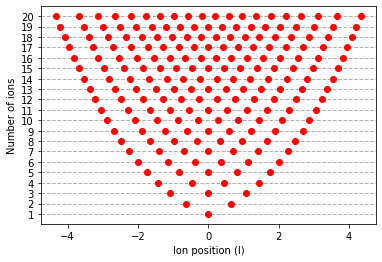

In [ ]:
l=((1.6e-19)**2*9e9/(9*1.66e-27*(2*np.pi*0.735e6)**2))**(1/3)*1e6 #wz = 0.15e6, axial freq 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) # plot grid 
grid_y_ticks = np.arange(0, 21, 1)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y')
for i in range(1,21):
    plt.plot(Eqposition3(i),i*np.ones(i), 'ro') # plot data
plt.ylabel('Number of ions')
plt.xlabel('Ion position (l)')
plt.grid(axis='y',linestyle='--', linewidth=1)
plt.savefig("equi_position.pdf", format="pdf", bbox_inches="tight")

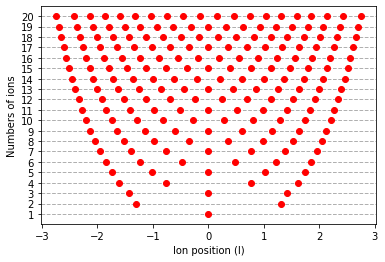

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) # plot grid 
grid_y_ticks = np.arange(0, 21, 1)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y')
for i in range(1,21):
    plt.plot(quarticEqposition(i,-1.6,1),i*np.ones(i), 'ro') # plot data
plt.ylabel('Numbers of ions')
plt.xlabel('Ion position (l)')
plt.grid(axis='y',linestyle='--', linewidth=1)
plt.savefig("equi_quartic_position.pdf", format="pdf", bbox_inches="tight")

In [ ]:
l=((1.6e-19)**2*9e9/(138*1.66e-27*(2*np.pi*0.735e6)**2))**(1/3)*1e6

In [ ]:
l

3.6128807615284173

We use $\omega_z$= 150 kHz, $\omega_{x,y}$= 6 MHz here for calculating the modes. 

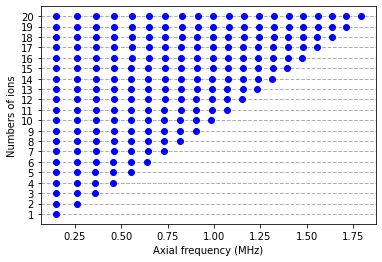

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
grid_y_ticks = np.arange(0, 21, 1) # plot grid
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y')
for i in range(1,21):
    plt.plot(Axialmodes(i, 0.15),i*np.ones(i), 'o',color='b') # plot data
    plt.ylabel('Numbers of ions')
    plt.xlabel('Axial frequency (MHz)')
    plt.grid(axis='y',linestyle='--', linewidth=1)

In [ ]:
spacing = Axialmodes(10,1)[1:]-Axialmodes(10,1)[:-1]

0.017015933990478516
0.017015457153320312


In [ ]:
np.std(spacing)/np.average(spacing)

0.0909242620589732

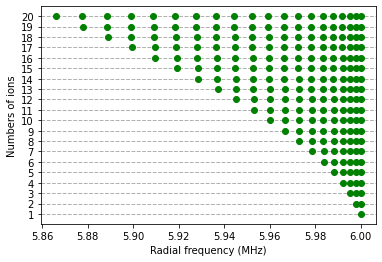

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
grid_y_ticks = np.arange(0, 21, 1) # plot grid
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y')
for i in range(1,21):
    plt.plot(Radialmodes(i, 0.15, 6),i*np.ones(i), 'o',color='green') # plot data
    plt.ylabel('Numbers of ions')
    plt.xlabel('Radial frequency (MHz)')
    plt.grid(axis='y',linestyle='--', linewidth=1)

In [ ]:
Eqposition2(300) # N=300 eqpositions and err

[-15.44301 -15.05427 -14.74452 -14.47569 -14.23327 -14.00982 -13.8009
 -13.60359 -13.41583 -13.23613 -13.06335 -12.8966  -12.73516 -12.57845
 -12.426   -12.27739 -12.13227 -11.99036 -11.8514  -11.71516 -11.58145
 -11.45009 -11.32092 -11.19381 -11.06863 -10.94526 -10.82361 -10.70358
 -10.58508 -10.46804 -10.35238 -10.23804 -10.12495 -10.01307  -9.90232
  -9.79267  -9.68407  -9.57647  -9.46984  -9.36413  -9.25931  -9.15535
  -9.05222  -8.94988  -8.84831  -8.74747  -8.64736  -8.54793  -8.44917
  -8.35105  -8.25356  -8.15667  -8.06037  -7.96464  -7.86945  -7.7748
  -7.68067  -7.58704  -7.49389  -7.40122  -7.30902  -7.21725  -7.12593
  -7.03502  -6.94453  -6.85443  -6.76473  -6.6754   -6.58645  -6.49785
  -6.4096   -6.32169  -6.23411  -6.14686  -6.05992  -5.97329  -5.88695
  -5.80091  -5.71515  -5.62967  -5.54446  -5.45951  -5.37482  -5.29037
  -5.20617  -5.12221  -5.03848  -4.95498  -4.87169  -4.78863  -4.70577
  -4.62311  -4.54065  -4.45839  -4.37631  -4.29442  -4.21271  -4.13117
  -4.049

In [ ]:
1.0545718e-34*(2*np.pi*np.sqrt(2)/(313.3e-9))**2/(2*9*1.66054e-27)/(2*np.pi*1000) #Yb+ recoil frequency#

451.6930219821873

The lower axial frequency makes a smaller Jij, because for each mode the sign is different, with lower axial freq the abs of these terms are closer, thus make a smaller Jij.

In [ ]:
Jij_x(1,2,10,0.6,0.6,0.95,4,4.122) #This is to compare with Islam's 2013 Science paper, result make sense#

27.916746123289197

In [ ]:
1.0545718e-34 *(2*np.pi*np.sqrt(2)/(313.3e-9))**2/(2*9*1.66054e-27)/(2*np.pi*1000)*0.007543645825404677 


3.40741217964035

In [ ]:
np.transpose(Radialfull(2,0.15,6)[1])[1][0] * np.transpose(Radialfull(2,0.15,6)[1])[1][1]/(6.1**2-Radialfull(2,0.15,6)[0][1]*0.15**2)

-0.40567949467046516

In [ ]:
(6.1**2-Radialfull(2,0.5,6)[0][1]*0.5**2)

1.4600006249776243

In [ ]:
# Spin-spin coupling profile
def Jijview(N):
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')

    x = np.array([[i] * N for i in range(N)]).ravel() + 1 # x coordinates of each bar
    y = np.array([i for i in range(N)] * N) + 1 # y coordinates of each bar
    z = np.zeros(N*N) # z coordinates of each bar
    dx = 0.6*np.ones(N*N) # length along x-axis of each bar
    dy = 0.6*np.ones(N*N) # length along y-axis of each bar
    dz = FullJij(N,1,1,1,6,6.1).ravel() # length along z-axis of each bar (height)
    ax1.view_init(50)
    plt.xlabel('Ion index i')
    plt.ylabel('Ion index j')
    plt.title('Jij (kHz)')
    ax1.bar3d(x, y, z, dx, dy, dz,color='blue',  edgecolor='gray')

# axial radial freq too different, interaction is short range

In [ ]:
FullJij(20,1,1,0.5,6,6.1)

0.18416905403137207


array([59.36479257,  0.        , 56.50050109, 31.81029307, 20.38479365,
       14.03055071, 10.11147002,  7.52422541,  5.73128186,  4.44245566,
        3.48904906,  2.76725245,  2.21020299,  1.77320646,  1.4254289 ,
        1.14494404,  0.91569717,  0.72543583,  0.56395237,  0.42003445])

0.03653740882873535


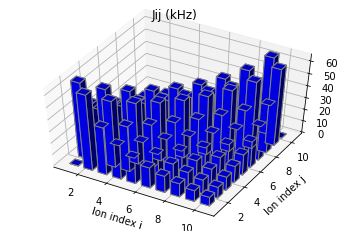

In [ ]:
Jijview(10)

I've check the symmetry of Jij and it makes sense.  Also compare to the Qsim example from Jiehang, doesn't look to fit very well. Need to check if $J_{i, j} \sim J /|i-j|^{\alpha}$. 

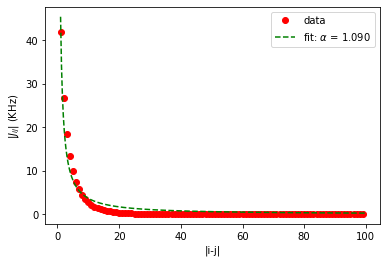

In [ ]:
Jijfit(100,1,1,0.15,6,6.1)

Plot flustrated Ising spin, compare to Kihwan's paper https://www.nature.com/articles/nature09071.pdf
I've checked the case with Yb+, 369.5 nm beam, $\omega_x$= 4.334 MHz, $\omega_z$ = 1.49 MHz, the number is roughly right but I don't know the Rabi frequency so cannot confirm

In [ ]:
mu = np.arange(-4, 1, 0.001)
plt.plot(mu,Jij_x(1,2,3,1,1,0.15,6, np.sqrt(mu*(0.15**2)+6**2)),'o', markersize=2, label = '$J_1$')
plt.plot(mu,Jij_x(1,3,3,1,1,0.15,6, np.sqrt(mu*(0.15**2)+6**2)),'ro',markersize=2, label = '$J_2$')
plt.ylim(-50000, 50000)
plt.legend()
plt.xlabel('$\mu^\prime = ( \mu^2 - \omega_x^2 )/\omega_z $')
plt.ylabel('J (2$\pi$ *KHz)')
plt.title('Flustrated Ising Spins Be+')
plt.show()

ValueError: operands could not be broadcast together with shapes (5000,) (3,) 

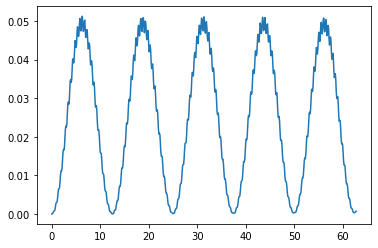

In [ ]:
# time plot in us
t=np.arange(0,20*np.pi,0.1)
plt.plot(t, phononerr(1,0, 5,0.15,6, 6.5,t))


Text(0, 0.5, '$ |a(t)|^2$')

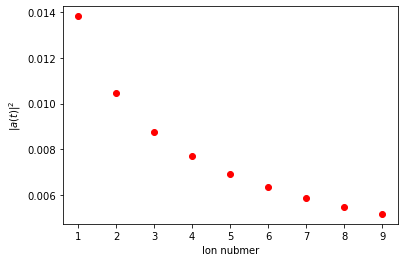

In [ ]:
# ion number plot sum over m


for N in range(1,10):
    plt.plot(N, alpha_sum_m(1, 0, N, 0.7,6, 6.1, 1),'ro')
plt.xlabel('Ion nubmer')
plt.ylabel('$ |a(t)|^2$')

In [ ]:
alpha_sum_m(1, 5, 100, 0.15,6, 6.1, 1)

0.002999668178906761

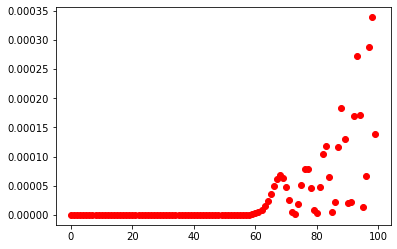

In [ ]:
for N in range(0,100):
     plt.plot(N,np.absolute(alpha_im(1, 5,N, 100, 0.15,6, 6.1, 1))**2,'ro')

In [ ]:
Radialmodes(100,0.15,6)

array([2.89277245, 2.97447977, 3.05335264, 3.12970448, 3.20363252,
       3.27539644, 3.34504439, 3.41273124, 3.47859454, 3.54266991,
       3.60513232, 3.66604675, 3.72541389, 3.78334727, 3.83998211,
       3.89525746, 3.9493786 , 4.00217672, 4.05386372, 4.10444331,
       4.15399784, 4.20245154, 4.24995943, 4.29647789, 4.3420396 ,
       4.38664513, 4.43040634, 4.47334787, 4.51545876, 4.55667982,
       4.59716869, 4.63685726, 4.67577767, 4.71395291, 4.75144021,
       4.78818286, 4.82426768, 4.85966677, 4.89439423, 4.92844161,
       4.96187854, 4.9946799 , 5.02684943, 5.05843695, 5.08940603,
       5.11979511, 5.14961774, 5.17883775, 5.20748535, 5.23559306,
       5.2631547 , 5.29016506, 5.3166458 , 5.34258805, 5.36800895,
       5.39291382, 5.41730149, 5.44117601, 5.46453748, 5.48740619,
       5.50977415, 5.53165164, 5.55304293, 5.57393872, 5.59435277,
       5.61429152, 5.63373834, 5.65271052, 5.671214  , 5.68923885,
       5.7067857 , 5.72386273, 5.74046973, 5.7566058 , 5.77227

In [ ]:
def RadialVar(x):
    return Radialmodes(20,x,6)[0]-1
sol = fsolve(RadialVar,0.7)

In [ ]:
sol

array([0.70390274])

In [ ]:
Radialmodes(20,0.70390274,6)

array([1.00000015, 1.98351554, 2.60025879, 3.07888969, 3.47673223,
       3.81887821, 4.11898526, 4.38546166, 4.62387913, 4.83811527,
       5.03098135, 5.20452826, 5.36027818, 5.49933896, 5.62246212,
       5.73008557, 5.82229896, 5.89876598, 5.95856696, 6.        ])

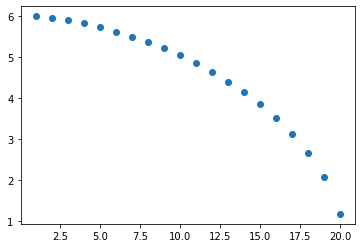

In [ ]:
plt.plot(np.arange(1,21),np.flip(Radialmodes(20,0.7,6)),'o')

In [ ]:
def Radialfit(N, wz, wx ): # fitting function
    def fitfunc(x,a,b):
        return a/(x**b)
    xdata = np.arange(1,N+1) # fitting data
    ydata = np.flip(Radialmodes(N, wz, wx))
    popt, pcov = curve_fit(fitfunc, xdata, ydata)
    plt.plot(xdata,ydata,'ro', label='data') #plot data and fit
    plt.plot(np.arange(1,N,0.3), fitfunc(np.arange(1,N,0.3), *popt), 'g--', label=r'fit: $\alpha$ = %5.3f' % tuple(popt)[1])
    plt.xlabel('|i-j|')
    plt.ylabel(r'|$J_{ij}$| (KHz)')
    plt.legend()
    plt.show()

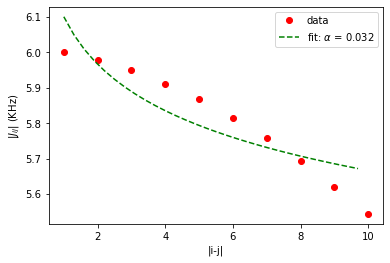

In [ ]:
Radialfit(10,0.5,6)